
# 📊 Analyse des Sentiments et Prédiction de Ratings

## 📝 Description du Projet

Ce projet vise à créer un modèle de prédiction de ratings basé sur l'analyse des commentaires clients (notebook data_cleaning).
L'objectif est de développer un système capable de prédire automatiquement la note (de 1 à 5 étoiles) 
qu'un client donnerait à partir de son commentaire textuel.


## 🎯 Objectifs

1. Analyser la distribution des ratings existants (notebook data_cleaning   )
2. Créer un modèle de prédiction performant (notebook ML)
3. Évaluer la qualité des prédictions (notebook ML)
4. Mettre en place un système de monitoring (notebook ML)
5. Déployer le modèle via Streamlit (fichier streamlit/app.py)


### 🔍 Structure du Notebook
1. Configuration et chargement des données
2. Analyse exploratoire
3. Préparation des données
4. Modélisation
5. Évaluation des résultats
6. Analyse du drift
7. Tests et conclusions

In [1]:
# Suppression des avertissements pour éviter de les afficher dans la sortie
import warnings
warnings.filterwarnings("ignore")

# Temps d'attente (sleep) en cas d'attente nécessaire dans les processus (utile pour Selenium si nécessaire)
from time import sleep
import json
# Bibliothèques pour la manipulation des données
import pandas as pd
import numpy as np
import datetime

# Bibliothèques pour les graphiques
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK : pour le traitement du texte
import nltk
from nltk.corpus import stopwords, words
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

# Wordcloud : pour la visualisation de nuages de mots
import wordcloud
from wordcloud import WordCloud

# Bibliothèques pour l'analyse de sentiments et autres tâches NLP
import re
import joblib

# Gérer les fichiers et répertoires locaux
import os

# Si nécessaire, on peut décommenter et installer les bibliothèques suivantes (elles sont en commentaire ici)
# from selenium import webdriver
# from webdriver_manager.chrome import ChromeDriverManager
# from selenium.webdriver.common.keys import Keys
# from bs4 import BeautifulSoup as bs
# import requests

# Télécharger les ressources NLTK si nécessaire
nltk.download('omw-1.4', quiet=True)  # Pour éviter les téléchargements répétitifs
nltk.download('punkt', quiet=True)    # Si tu utilises word_tokenize
nltk.download('stopwords', quiet=True) # Pour les stopwords
nltk.download('vader_lexicon', quiet=True) # Si tu utilises SentimentIntensityAnalyzer


True

In [2]:
# Charger le JSON dans un DataFrame
df = pd.read_json("df_selected.json", orient="records")

# Afficher les premières lignes
df.head()

,cat_response,commentaire_text,positive_emojis,negative_emojis,sentiment,num_special_characters,num_uppercase_characters,total_characters,nombre_point_exclam,nombre_point_intero,char_bins,rating,diff_experience_review,diff_review_response,commentaire_en_sans_SW
0,0,MERCI Bonjour je mets 5 étoiles car j'ai eu to...,0,0,Positif,7,7,329,1,0,Très Long,5,6,42,Thank hello put 5 stars help needed customer s...
1,0,"Rapide , simple et efficace Très accessible , ...",0,0,Positif,9,4,289,0,0,Très Long,5,8,43,"Fast, simple efficient accessible, answer fill..."
2,0,Réponse ultra rapide et surtout Réponse ultra ...,0,0,Positif,9,5,330,0,0,Très Long,5,7,47,Ultra fast response especially ultra fast acce...
3,0,Rapport service client au top Rapport service ...,0,0,Positif,6,4,177,0,0,Très Long,5,8,42,Customer service report top customer service r...
4,0,Elle m'a permise de réaliser mon projet Elle m...,0,0,Positif,3,2,149,0,0,Très Long,5,5,42,"allowed carry project, allowed carry longtime ..."


In [3]:
# Définir le dossier de données NLTK
nltk_data_folder = os.path.join(os.getcwd(), 'nltk_data')
os.environ['NLTK_DATA'] = nltk_data_folder
print(os.environ['NLTK_DATA'])

# Téléchargement des ressources nécessaires pour NLTK
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Initialisation de l'analyseur de sentiments
sia = SentimentIntensityAnalyzer()

def analyse_sentiments(text):
    """Analyse de sentiment et renvoie 1 pour positif, 0 pour négatif"""
    sentiment_scores = sia.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    if compound_score >= 0.05:
        sentiment_label = 1  # positif
    elif compound_score <= -0.05:
        sentiment_label = 0  # négatif
    else:
        sentiment_label = -1  # neutre
    return sentiment_label

# Fonction pour extraire les valeurs manquantes d'une colonne
def VM(dff, column_name):
    """Retourne les lignes avec des valeurs manquantes dans la colonne spécifiée"""
    mask = pd.isna(dff[column_name])
    df_vm = dff[mask]
    return df_vm

# Fonction pour afficher les informations d'un avis client basé sur un indice
def afficher(df, indice):
    """Affiche les valeurs d'un avis client à un indice donné"""
    print(f'Valeurs pour indice {indice}')
    for colonne in df.columns:
        print(f'{colonne} :------> {df[colonne][indice]}')

# POS Tagging : Tokenisation et étiquetage grammatical des mots


def POStagging(commentaire):  
    """Effectue le POS tagging sur un texte donné"""
    text = []
    sentences = sent_tokenize(commentaire)
    for s in sentences:
        wordsList = nltk.word_tokenize(s)
        tagged = nltk.pos_tag(wordsList)
        tagged = ' '.join(map(lambda X: '_'.join(X), tagged))  # Formatage du token_tag
        text.append(tagged)
    return ' '.join(text)

# Exemple d'utilisation pour tester
# print(POStagging('I like programming.'))

c:\Users\mbouc\supply_sentiment - Copie\data treatment\Prediction\nltk_data


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\mbouc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print('Valeurs manquantes:')
valeurs_manquantes = df.isna().sum()
valeurs_manquantes[valeurs_manquantes > 0]


Valeurs manquantes:


Series([], dtype: int64)

In [5]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to C:\Users\mbouc/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [6]:
wordnet_lemmatizer = WordNetLemmatizer()

## supprimer les points, virgules...
df['commentaire_en_sans_SW'] = df['commentaire_en_sans_SW'].str.replace('[^\w\s]', ' ')

df['stemmed'] = [[wordnet_lemmatizer.lemmatize(word, pos="v") for word in review.split()] for review in df['commentaire_en_sans_SW']]
## transformer le text en miniscule
df['lower_cased']=[[word.lower() for word in s] for s in df['stemmed']]

# importing stopwors from nltk library

nltk.download('stopwords')
nltk.download('stopwords', download_dir=nltk_data_folder)

a = set(stopwords.words("english"))
# ajout colonne sans stop word
df['stopwordsremoved']=[[word for word in s if word not in a] for s in df['lower_cased']]

## supprimer les mots qui ne sont pas dans le dictionnaire anglais
english_words = set(words.words())
df['filtered_words']=[[word for word in s if word in english_words] for s in df['stopwordsremoved']]

## concatener les mot
df['commentaire_clean'] = [' '.join(review) for review in df['filtered_words']]

## création d'une nouvelle colonne "Analyse_sentiment_commentaire"
df['sentiment_commentaire'] = df['commentaire_clean'].apply(lambda x: analyse_sentiments(x))
# df= pd.get_dummies(df, columns=['sentiment_commentaire'], prefix='sentiment')

## supprimer les colonnes inutiles
colonnes_à_supprimer = ['commentaire_en_sans_SW', 'stemmed','lower_cased', 'stopwordsremoved', 'filtered_words']
df = df.drop(columns = colonnes_à_supprimer)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\mbouc\supply_sentiment - Copie\data
[nltk_data]     treatment\Prediction\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Définir un chemin plus simple pour stocker les données NLTK
nltk_data_dir = r"C:\Users\mbouc\nltk_data"  # Assure-toi que ce dossier existe
os.makedirs(nltk_data_dir, exist_ok=True)

# Ajouter ce chemin à la liste de recherche NLTK
nltk.data.path.append(nltk_data_dir)

# Télécharger les données nécessaires
nltk.download('words', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)  # Utile pour la tokenisation

print("Téléchargement terminé. Vérifie si le problème est résolu.")

Téléchargement terminé. Vérifie si le problème est résolu.


[nltk_data] Downloading package words to C:\Users\mbouc\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbouc\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\mbouc\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\mbouc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
import nltk
nltk.data.path = ['C:/Users/mbouc/nltk_data']  # Change selon ton dossier de préférence
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\mbouc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\mbouc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [13]:
def POStagging(comment, return_list=False):  
    """
    Effectue le POS tagging sur un texte donné.

    :param comment: Texte à analyser.
    :param return_list: Si True, retourne une liste de tuples (mot, tag).
    :return: Texte annoté sous forme de chaîne ou de liste de tuples.
    """
    if not isinstance(comment, str) or not comment.strip():
        return "" if not return_list else []

    sentences = sent_tokenize(comment)
    tagged_words = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged = pos_tag(words)
        tagged_words.extend(tagged)

    if return_list:
        return tagged_words

    return ' '.join([f"{word}_{tag}" for word, tag in tagged_words])

# Exemple d'utilisation :
print(POStagging('I am like you.'))
print(POStagging('I like you.', return_list=True))

I_PRP am_VBP like_IN you_PRP ._.
[('I', 'PRP'), ('like', 'VBP'), ('you', 'PRP'), ('.', '.')]


In [14]:
### application de postagging à la colonne commentaire_clean pour destinguer les ngram...
# temps execution: 2 minutes
df['commentaire_clean_pos_tag'] = df['commentaire_clean'].apply(lambda x: POStagging(x))

In [15]:
df.head(2)

,cat_response,commentaire_text,positive_emojis,negative_emojis,sentiment,num_special_characters,num_uppercase_characters,total_characters,nombre_point_exclam,nombre_point_intero,char_bins,rating,diff_experience_review,diff_review_response,commentaire_clean,sentiment_commentaire,commentaire_clean_pos_tag
0,0,MERCI Bonjour je mets 5 étoiles car j'ai eu to...,0,0,Positif,7,7,329,1,0,Très Long,5,6,42,thank hello put star help need customer servic...,1,thank_NN hello_NN put_VBD star_NN help_NN need...
1,0,"Rapide , simple et efficace Très accessible , ...",0,0,Positif,9,4,289,0,0,Très Long,5,8,43,simple efficient answer fill different attach ...,1,simple_JJ efficient_JJ answer_NN fill_NN diffe...


In [16]:
## test de la foction analyse_sentiments
text1 = "AMAZING!"
text2 = "love happy bad horrible"
text3 = "very bad horrible!"
text4 = 'awful, run away'
print(analyse_sentiments(text1))
print(analyse_sentiments(text2))
print(analyse_sentiments(text3))
print(analyse_sentiments(text4))

1
1
0
0


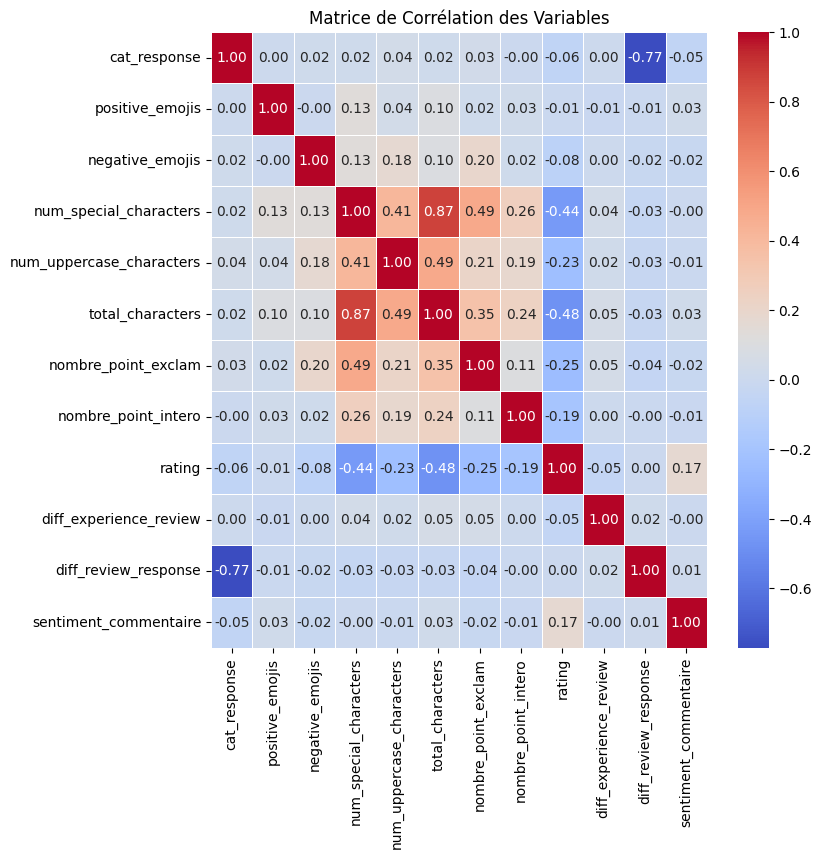

In [17]:
# Sélectionner uniquement les colonnes numériques pour le calcul de la corrélation
numeric_df = df.select_dtypes(include=[np.number])

# Calcul de la corrélation entre les variables numériques
cor = numeric_df.corr()

# Création de la figure et de l'axe pour le graphique
fig, ax = plt.subplots(figsize=(8,8))

# Affichage de la carte thermique (heatmap)
sns.heatmap(cor, annot=True, ax=ax, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title('Matrice de Corrélation des Variables')

# Affichage du graphique
plt.show()

In [18]:
cor

,cat_response,positive_emojis,negative_emojis,num_special_characters,num_uppercase_characters,total_characters,nombre_point_exclam,nombre_point_intero,rating,diff_experience_review,diff_review_response,sentiment_commentaire
cat_response,1.000000,0.003571,0.022773,0.022675,0.042152,0.020387,0.031044,-0.000760,-0.061982,0.003682,-0.772009,-0.052168
positive_emojis,0.003571,1.000000,-0.002929,0.128884,0.040998,0.095389,0.021463,0.029951,-0.010503,-0.012714,-0.009112,0.028719
negative_emojis,0.022773,-0.002929,1.000000,0.132048,0.175335,0.096159,0.195762,0.019797,-0.080231,0.004658,-0.020728,-0.018712
num_special_characters,0.022675,0.128884,0.132048,1.000000,0.414886,0.874551,0.486083,0.255626,-0.436716,0.042333,-0.031668,-0.003119
num_uppercase_characters,0.042152,0.040998,0.175335,0.414886,1.000000,0.485280,0.214143,0.189312,-0.234243,0.024625,-0.030662,-0.005399
total_characters,0.020387,0.095389,0.096159,0.874551,0.485280,1.000000,0.345685,0.237555,-0.479563,0.054084,-0.026029,0.025819
nombre_point_exclam,0.031044,0.021463,0.195762,0.486083,0.214143,0.345685,1.000000,0.106509,-0.251773,0.048485,-0.042236,-0.018773
nombre_point_intero,-0.000760,0.029951,0.019797,0.255626,0.189312,0.237555,0.106509,1.000000,-0.192890,0.003973,-0.004886,-0.011839
rating,-0.061982,-0.010503,-0.080231,-0.436716,-0.234243,-0.479563,-0.251773,-0.192890,1.000000,-0.046030,0.001869,0.172845
diff_experience_review,0.003682,-0.012714,0.004658,0.042333,0.024625,0.054084,0.048485,0.003973,-0.046030,1.000000,0.022332,-0.002945


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5504 entries, 0 to 5503
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   cat_response               5504 non-null   int64 
 1   commentaire_text           5504 non-null   object
 2   positive_emojis            5504 non-null   int64 
 3   negative_emojis            5504 non-null   int64 
 4   sentiment                  5504 non-null   object
 5   num_special_characters     5504 non-null   int64 
 6   num_uppercase_characters   5504 non-null   int64 
 7   total_characters           5504 non-null   int64 
 8   nombre_point_exclam        5504 non-null   int64 
 9   nombre_point_intero        5504 non-null   int64 
 10  char_bins                  5504 non-null   object
 11  rating                     5504 non-null   int64 
 12  diff_experience_review     5504 non-null   int64 
 13  diff_review_response       5504 non-null   int64 
 14  commenta

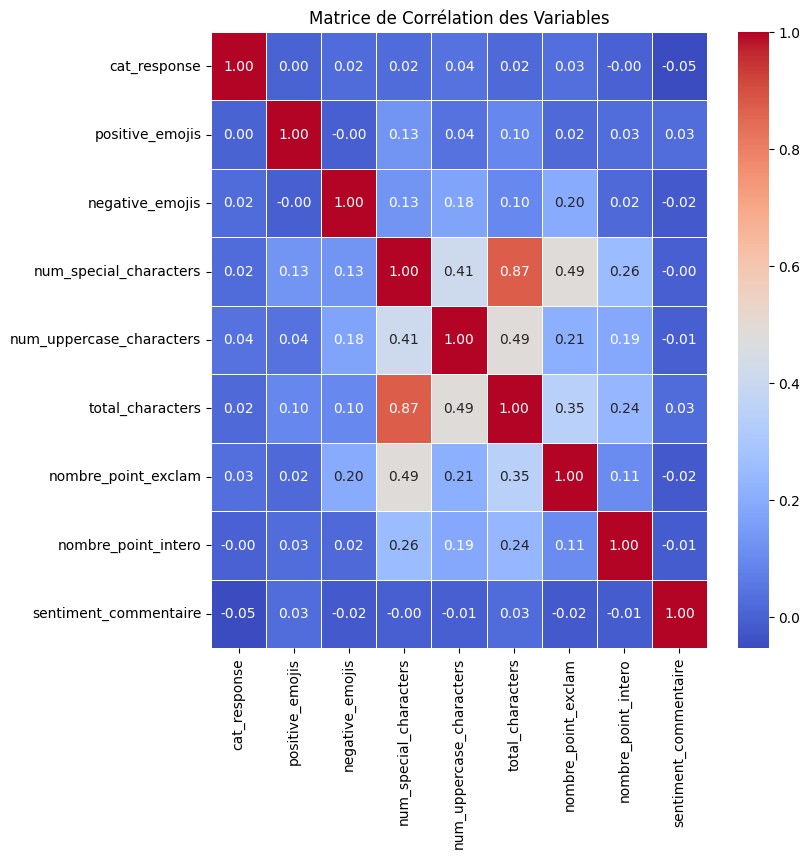

In [20]:

# Colonnes à conserver pour la prédiction de la note
colonnes_a_garder = [
    'cat_response', 'positive_emojis', 'negative_emojis', 'num_special_characters', 
    'num_uppercase_characters', 'total_characters', 'nombre_point_exclam', 
    'nombre_point_intero', 'sentiment_commentaire'
]

# Calcul de la corrélation entre les variables numériques
cor = df[colonnes_a_garder].corr()

# Création de la figure et de l'axe pour le graphique
fig, ax = plt.subplots(figsize=(8,8))

# Affichage de la carte thermique (heatmap)
sns.heatmap(cor, annot=True, ax=ax, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title('Matrice de Corrélation des Variables')

# Affichage du graphique
plt.show()

In [21]:
cor

,cat_response,positive_emojis,negative_emojis,num_special_characters,num_uppercase_characters,total_characters,nombre_point_exclam,nombre_point_intero,sentiment_commentaire
cat_response,1.000000,0.003571,0.022773,0.022675,0.042152,0.020387,0.031044,-0.000760,-0.052168
positive_emojis,0.003571,1.000000,-0.002929,0.128884,0.040998,0.095389,0.021463,0.029951,0.028719
negative_emojis,0.022773,-0.002929,1.000000,0.132048,0.175335,0.096159,0.195762,0.019797,-0.018712
num_special_characters,0.022675,0.128884,0.132048,1.000000,0.414886,0.874551,0.486083,0.255626,-0.003119
num_uppercase_characters,0.042152,0.040998,0.175335,0.414886,1.000000,0.485280,0.214143,0.189312,-0.005399
total_characters,0.020387,0.095389,0.096159,0.874551,0.485280,1.000000,0.345685,0.237555,0.025819
nombre_point_exclam,0.031044,0.021463,0.195762,0.486083,0.214143,0.345685,1.000000,0.106509,-0.018773
nombre_point_intero,-0.000760,0.029951,0.019797,0.255626,0.189312,0.237555,0.106509,1.000000,-0.011839
sentiment_commentaire,-0.052168,0.028719,-0.018712,-0.003119,-0.005399,0.025819,-0.018773,-0.011839,1.000000


### Colonnes directement liées au `rating` :

#### `sentiment_commentaire` :
- **Corrélation** : 0.172845
- Cette variable a une corrélation modérée avec `rating`, ce qui en fait une caractéristique importante à garder pour prédire la note.

### Colonnes qui peuvent avoir un impact indirect :

#### `num_special_characters` et `total_characters` :
- **Corrélation** : -0.436716 et -0.479563 respectivement
- Ces deux colonnes montrent une corrélation négative avec `rating`. Cela signifie que, potentiellement, un nombre plus élevé de caractères ou de caractères spéciaux pourrait être associé à une note plus basse, ou vice versa. Ces colonnes peuvent être utiles pour affiner ton modèle.

#### `nombre_point_exclam` et `nombre_point_intero` :
- **Corrélation** : Ces colonnes ont une corrélation plus faible avec `rating`. Mais elles indiquent l'intensité ou l'émotion dans le commentaire, ce qui pourrait affecter la note de manière subtile.

### Colonnes moins importantes ou ayant une faible corrélation avec `rating` :

#### `positive_emojis` et `negative_emojis` :
- Les emojis positifs et négatifs ont des corrélations très faibles avec `rating`. Bien qu'ils puissent influencer l'analyse de sentiment, leur impact direct sur la note semble limité ici.

#### `cat_response` :
- La corrélation avec `rating` est proche de zéro (-0.061982), ce qui signifie que cette variable n'a qu'un faible impact sur la note.

### Conclusion et recommandations :

Pour prédire `rating`, il semble préférable de conserver les colonnes qui ont une corrélation plus significative avec `rating` et qui peuvent affecter directement ou indirectement la note des avis.

#### Colonnes à garder pour le modèle :
1. `sentiment_commentaire` (corrélation modérée avec `rating`)
2. `num_special_characters` (corrélation modérée avec `rating`)
3. `total_characters` (corrélation modérée avec `rating`)
4. `nombre_point_exclam` (corrélation modérée avec `rating`)
5. `nombre_point_intero` (corrélation faible mais peut-être utile)

#### Colonnes à supprimer ou tester avec précaution :
1. `positive_emojis` (très faible corrélation avec `rating`)
2. `negative_emojis` (très faible corrélation avec `rating`)
3. `cat_response` (très faible corrélation avec `rating`) # la reponse vient apres l'avis

On peut également essayer d'intégrer toutes les colonnes dans un modèle et utiliser des techniques comme la sélection de caractéristiques ou la régularisation pour identifier les colonnes les plus pertinentes pendant l'entraînement du modèle.


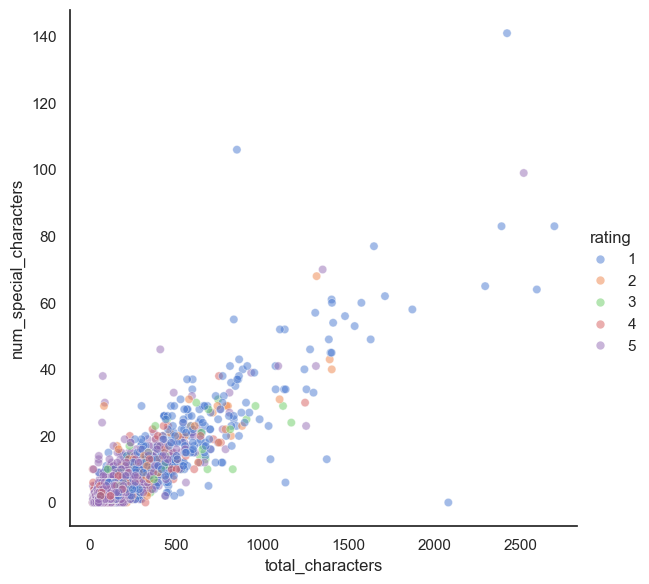

In [22]:
sns.set_theme(style="white")

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="total_characters", y="num_special_characters", hue="rating", #size="sentiment_commentaire",
            sizes=(40, 400), alpha=.5, palette="muted",  height=6, data = df)

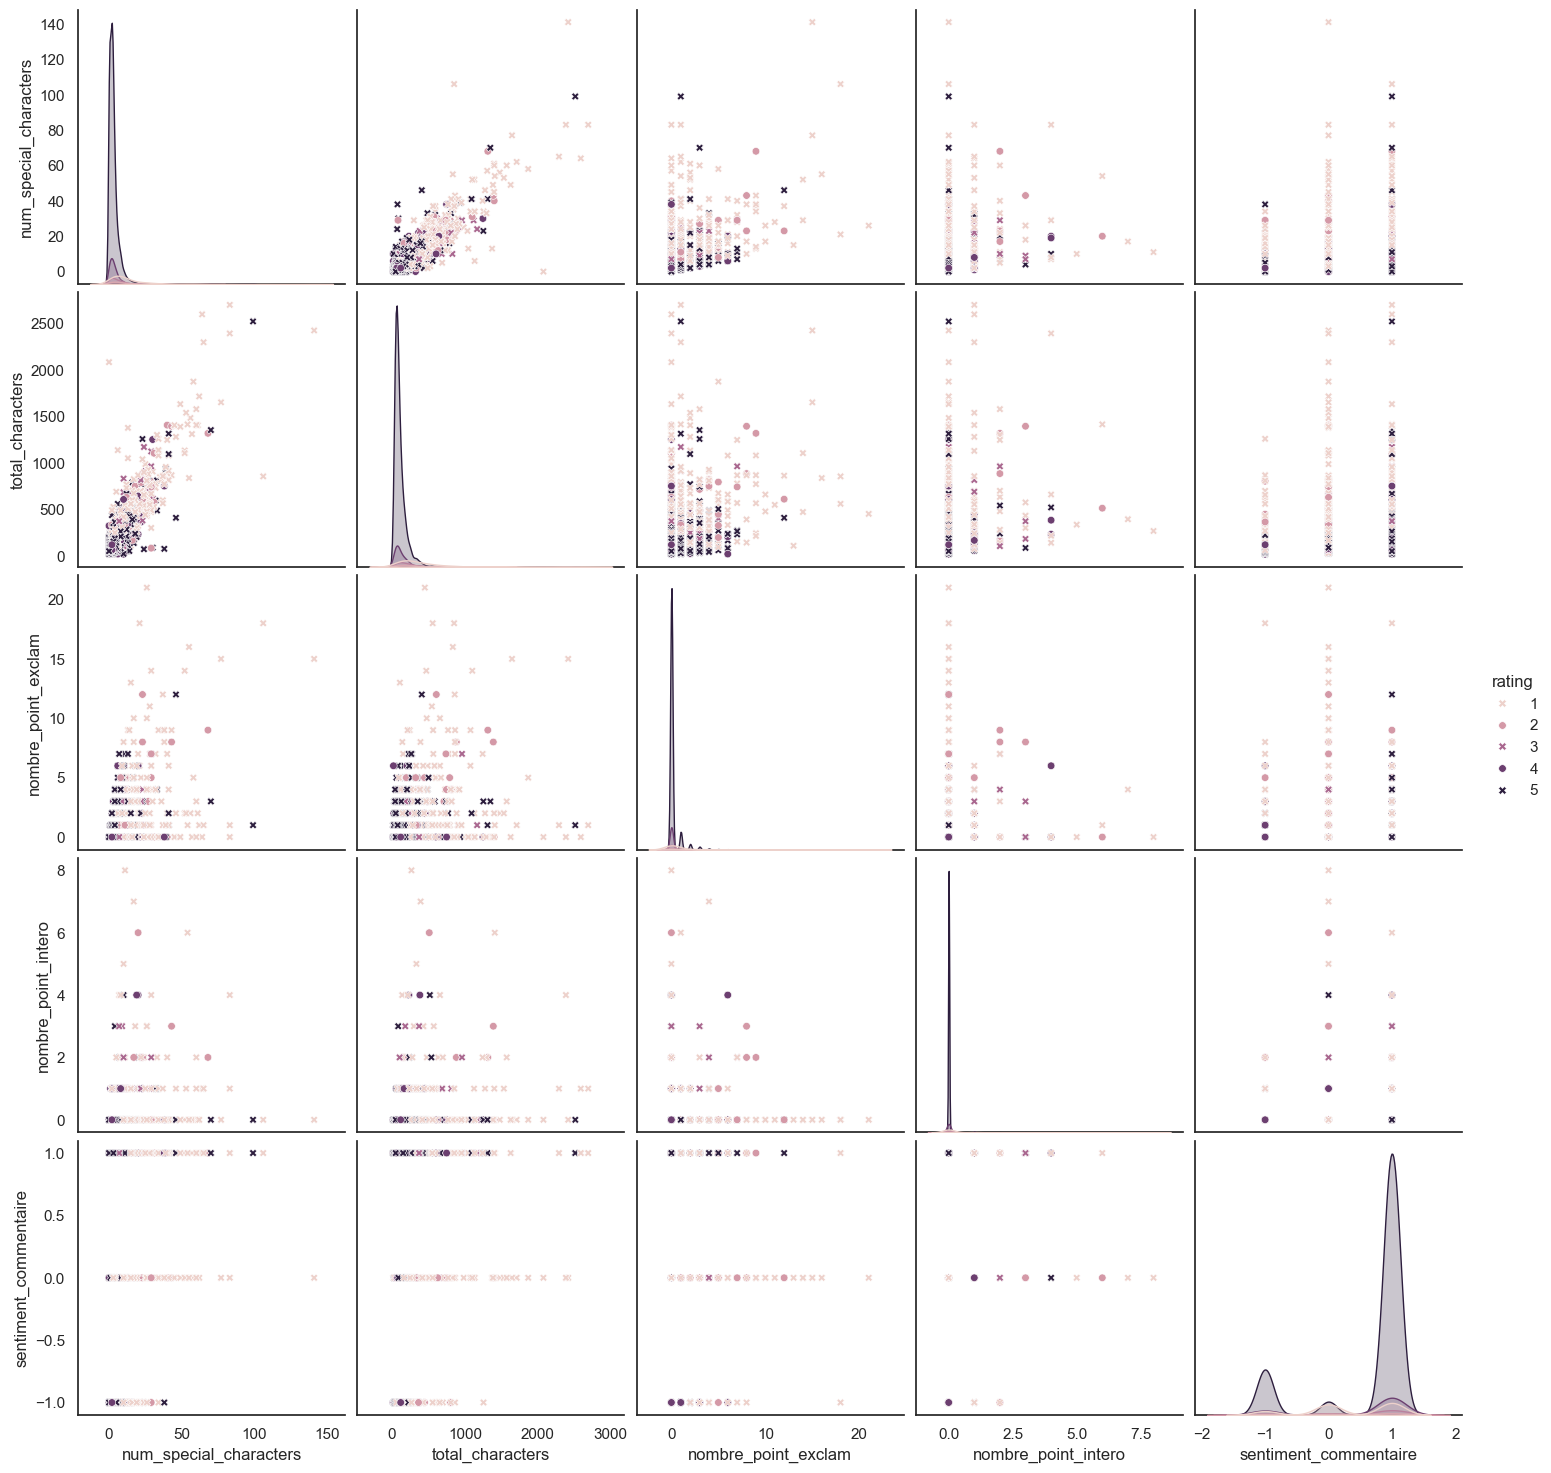

In [23]:
# Définir les colonnes à afficher
cols= ['num_special_characters', 'total_characters', 'nombre_point_exclam', 'nombre_point_intero', 'sentiment_commentaire']

# Créer un pairplot avec les données
sns.set_theme(style="white")

# Supposons que 'rating' est une colonne catégorique qui contient les étiquettes de classe
sns.pairplot(data=df, hue='rating', vars=cols, height=3, plot_kws={"s": 30}, markers=['X', 'o'])

# Afficher le graphique
plt.show()


In [24]:
#Affiche le nombre de doublons
print("Avant suppression duplicates", df.shape)

nombre_doublon = df.duplicated().sum()
print("Nombre de doublons :", nombre_doublon)

#Supprime les doublons
df = df.drop_duplicates()
print(nombre_doublon , "lignes doublons supprimées:")

print("Après suppression duplicates", df.shape)


Avant suppression duplicates (5504, 17)
Nombre de doublons : 25
25 lignes doublons supprimées:
Après suppression duplicates (5479, 17)


In [25]:
df.columns

Index(['cat_response', 'commentaire_text', 'positive_emojis',
       'negative_emojis', 'sentiment', 'num_special_characters',
       'num_uppercase_characters', 'total_characters', 'nombre_point_exclam',
       'nombre_point_intero', 'char_bins', 'rating', 'diff_experience_review',
       'diff_review_response', 'commentaire_clean', 'sentiment_commentaire',
       'commentaire_clean_pos_tag'],
      dtype='object')

In [26]:
## Supprission des colonnes inutiles
colonnes_à_supprimer = [ 'commentaire_text',  'diff_experience_review']
  
# ## supprimer les colonnes inutiles
data_prep = df.drop(columns=colonnes_à_supprimer)
joblib.dump(data_prep, "data_prep")

data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5479 entries, 0 to 5503
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   cat_response               5479 non-null   int64 
 1   positive_emojis            5479 non-null   int64 
 2   negative_emojis            5479 non-null   int64 
 3   sentiment                  5479 non-null   object
 4   num_special_characters     5479 non-null   int64 
 5   num_uppercase_characters   5479 non-null   int64 
 6   total_characters           5479 non-null   int64 
 7   nombre_point_exclam        5479 non-null   int64 
 8   nombre_point_intero        5479 non-null   int64 
 9   char_bins                  5479 non-null   object
 10  rating                     5479 non-null   int64 
 11  diff_review_response       5479 non-null   int64 
 12  commentaire_clean          5479 non-null   object
 13  sentiment_commentaire      5479 non-null   int64 
 14  commentaire_c

In [27]:
# Sauvegarde du DataFrame en JSON (format compact, chaque ligne est un objet JSON)
df.to_json("data_prep.json", orient="records", force_ascii=False, indent=4)

print("Le fichier data_prep.json a été sauvegardé avec succès !")

Le fichier data_prep.json a été sauvegardé avec succès !


### WORDCLOUD

In [28]:
import nltk
from nltk.corpus import stopwords
#Importer les packages nécessaires
from wordcloud import WordCloud

In [29]:
# Téléchargez la liste des stopwords si ce n'est pas déjà fait
nltk.download('stopwords')

# Supprimer les stopwords et créer une nouvelle colonne
stop_words = set(stopwords.words('english'))
df['commentaire_en_sans_SW'] = df['commentaire_clean'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Initialiser la variable des mots vides
stop_words = set(stopwords.words('english'))
# print(stop_words)

df1 = df.loc[df['rating'] == 1]
df2 = df.loc[df['rating'] == 2]
df3 = df.loc[df['rating'] == 3]
df4 = df.loc[df['rating'] == 4]
df5 = df.loc[df['rating'] == 5]

### regrouper le text de colonne "commentaire_en_sans_SW" dans une varialble text1 pour la note 1
text1 = ""
for comment in df1['commentaire_en_sans_SW']:
    text1 += comment
### regrouper le text de colonne "commentaire_en_sans_SW" dans une varialble text2 pour la note 2
text2 = ""
for comment in df2['commentaire_en_sans_SW']:
    text2 += comment
### regrouper le text de colonne "commentaire_en_sans_SW" dans une varialble text3 pour la note 3
text3 = ""
for comment in df3['commentaire_en_sans_SW']:
    text3 += comment
### regrouper le text de colonne "commentaire_en_sans_SW" dans une varialble text4 pour la note 4
text4 = ""
for comment in df4['commentaire_en_sans_SW']:
    text4 += comment
### regrouper le text de colonne "commentaire_en_sans_SW" dans une varialble text5 pour la note 5
text5 = ""
for comment in df5['commentaire_en_sans_SW']:
    text5 += comment

print('dimension de text1:',len(text1))
print('dimension de text2:',len(text2))
print('dimension de text3:',len(text3))
print('dimension de text4:',len(text4))
print('dimension de text5:',len(text5))

text_total = text1 + text2 + text3 + text4 + text5
print('\ndimension de text_total:',len(text_total))

dimension de text1: 85324
dimension de text2: 14659
dimension de text3: 18641
dimension de text4: 30972
dimension de text5: 206706

dimension de text_total: 356302


In [31]:
%matplotlib inline
# Définir le calque du nuage des mots
wc = WordCloud(background_color="black", max_words=100, stopwords=stop_words, max_font_size=50, random_state=42)

Pour la note 1, les mots qui reviennent le plus dans les commentaires sont: account, bank, time, problem....

In [32]:
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords, words

# Téléchargez les ressources nécessaires si ce n'est pas déjà fait
nltk.download('stopwords')
nltk.download('words')

def afficher_wordcloud_et_frequence(texte, titre="Analyse des mots", stopwords_anglais=True, nb_mots=20, couleurs="Pastel1"):
    """
    Affiche un nuage de mots et un graphique des fréquences des mots les plus courants, 
    avec des options pour personnaliser l'affichage.

    Paramètres :
    - texte : str → Texte à analyser
    - titre : str → Titre de l'analyse (ex: "Note 1", "Note 2")
    - stopwords_anglais : bool → Si True, ignore les mots vides en anglais.
    - nb_mots : int → Le nombre de mots à afficher dans le graphique des fréquences (par défaut 20)
    - couleurs : str → Palette de couleurs pour le nuage de mots (par défaut "Pastel1")
    """
    # Générer le WordCloud avec des couleurs personnalisées
    stop_words = set(stopwords.words("english")) if stopwords_anglais else set()
    wc = WordCloud(width=500, height=300, background_color="white", colormap=couleurs, stopwords=stop_words).generate(texte)

    # Calcul des fréquences des mots
    words = wc.process_text(texte)
    freq = nltk.FreqDist(words)

    # Récupérer les mots les plus fréquents (en fonction du nombre souhaité)
    mots_communs = freq.most_common(40)
    mots, valeurs = zip(*mots_communs)  # Séparer mots et fréquences

    # Création d'une figure avec 2 sous-graphiques
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Affichage du WordCloud
    axes[0].imshow(wc, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Nuage de mots - {titre}", fontsize=14, color='#3742fa')

    # Affichage du graphique des fréquences avec Matplotlib
    axes[1].barh(mots[::-1], valeurs[::-1], color='#2980b9')
    axes[1].set_xlabel("Nombre d'occurrences", fontsize=12)
    axes[1].set_ylabel("Mots", fontsize=12)
    axes[1].set_title(f"Fréquence des mots - {titre}", fontsize=14, color='#3742fa')

    # Ajout des valeurs sur chaque barre
    for i, v in enumerate(valeurs[::-1]):
        axes[1].text(v + 0.5, i, str(v), color='black', fontsize=10, va='center')

    plt.tight_layout()
    plt.show()

    # Retourner un DataFrame avec les mots et leurs fréquences pour analyse supplémentaire
    df_resultat = pd.DataFrame(list(zip(mots, valeurs)), columns=["Mot", "Fréquence"])
    return df_resultat

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbouc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\mbouc/nltk_data...
[nltk_data]   Package words is already up-to-date!


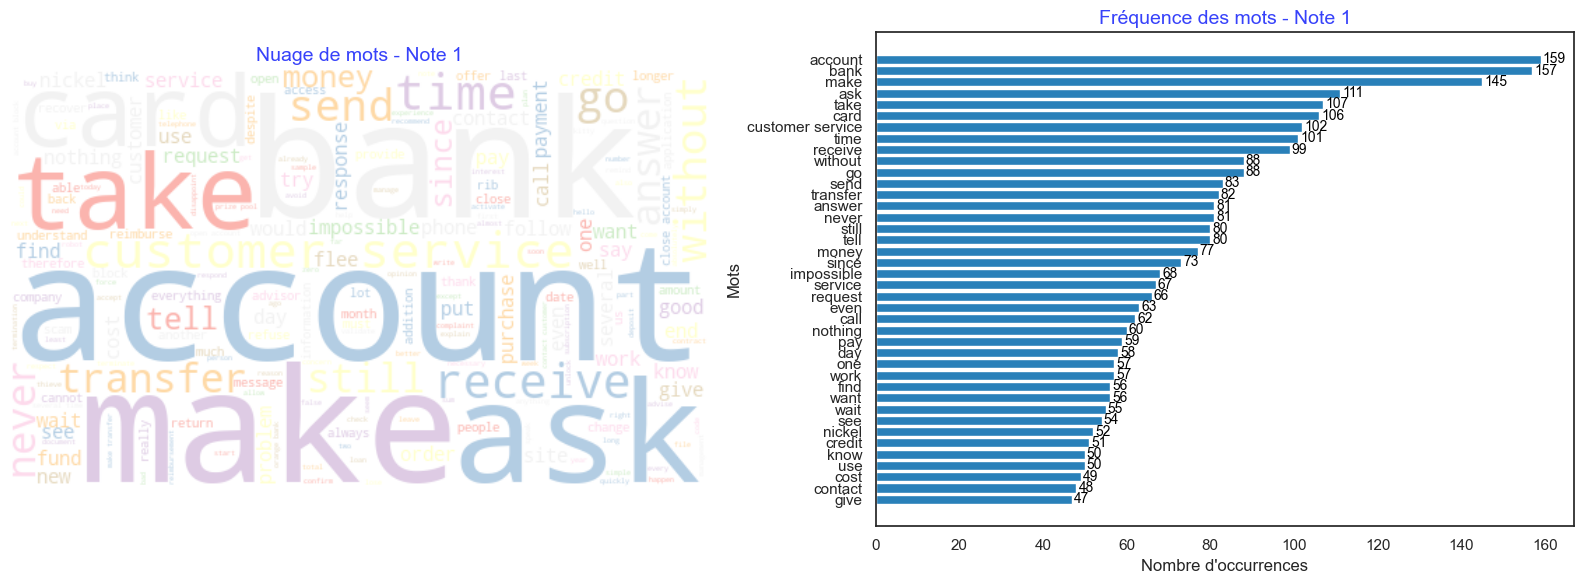

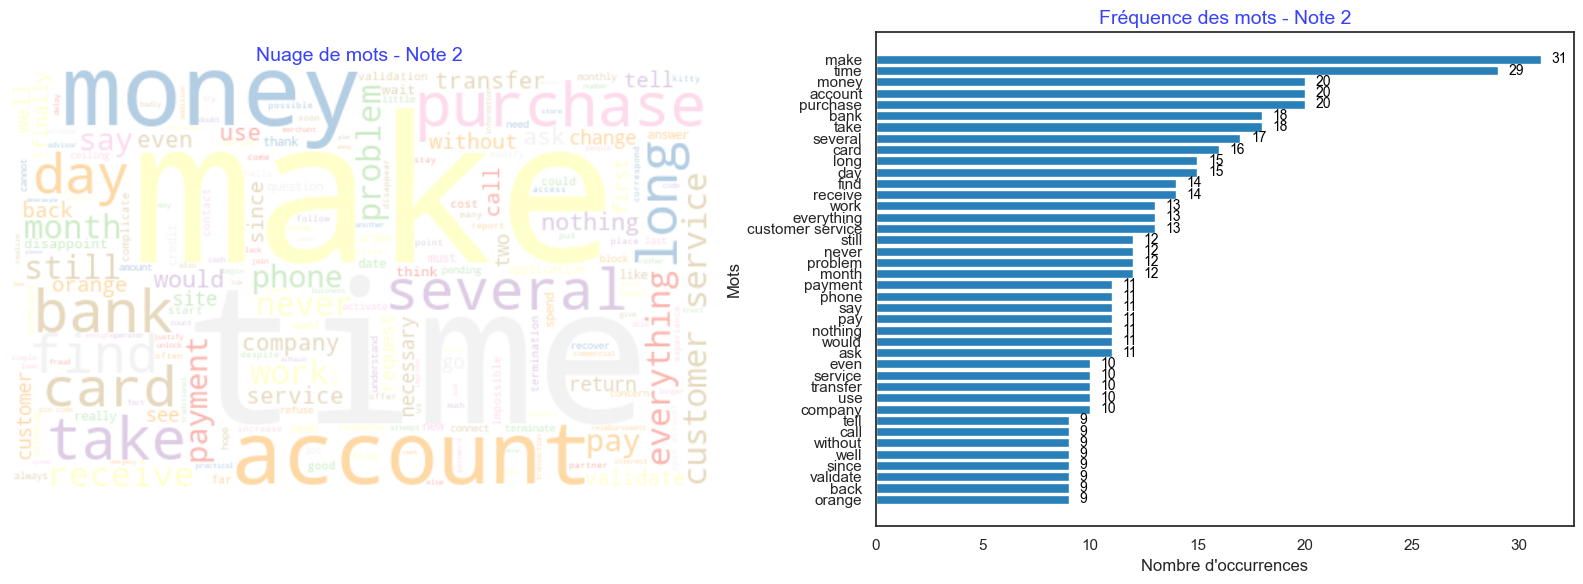

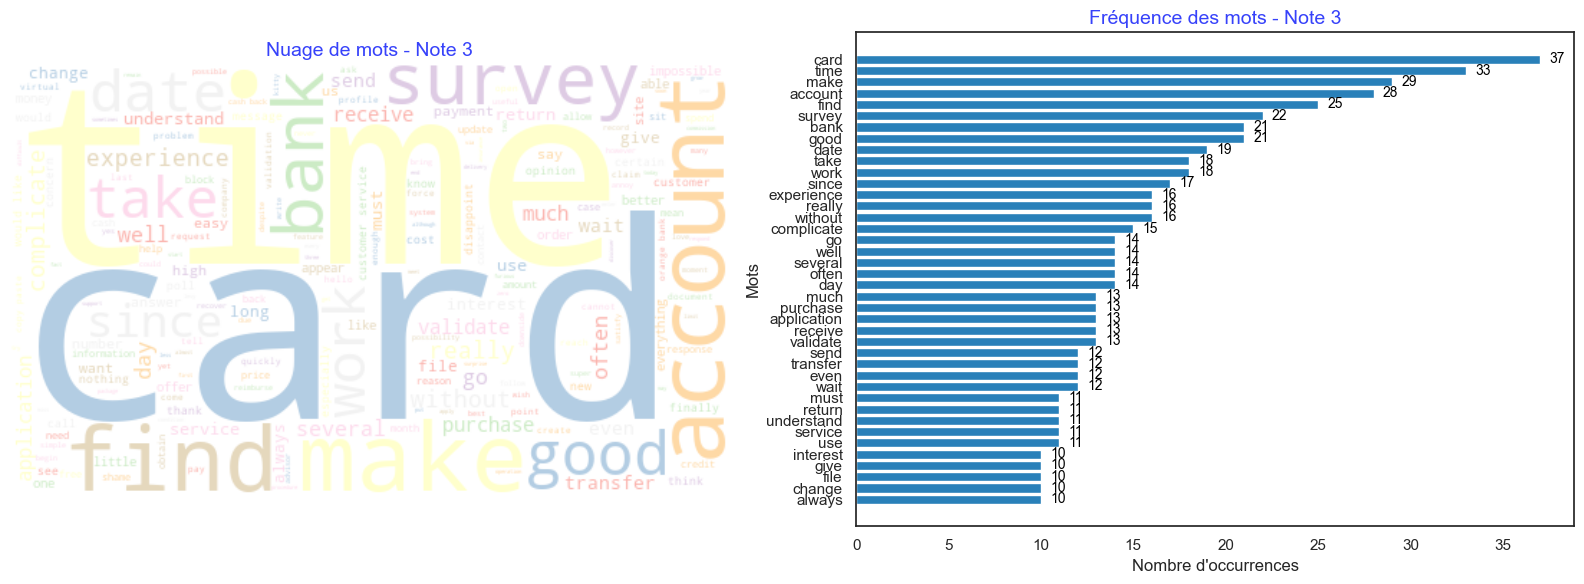

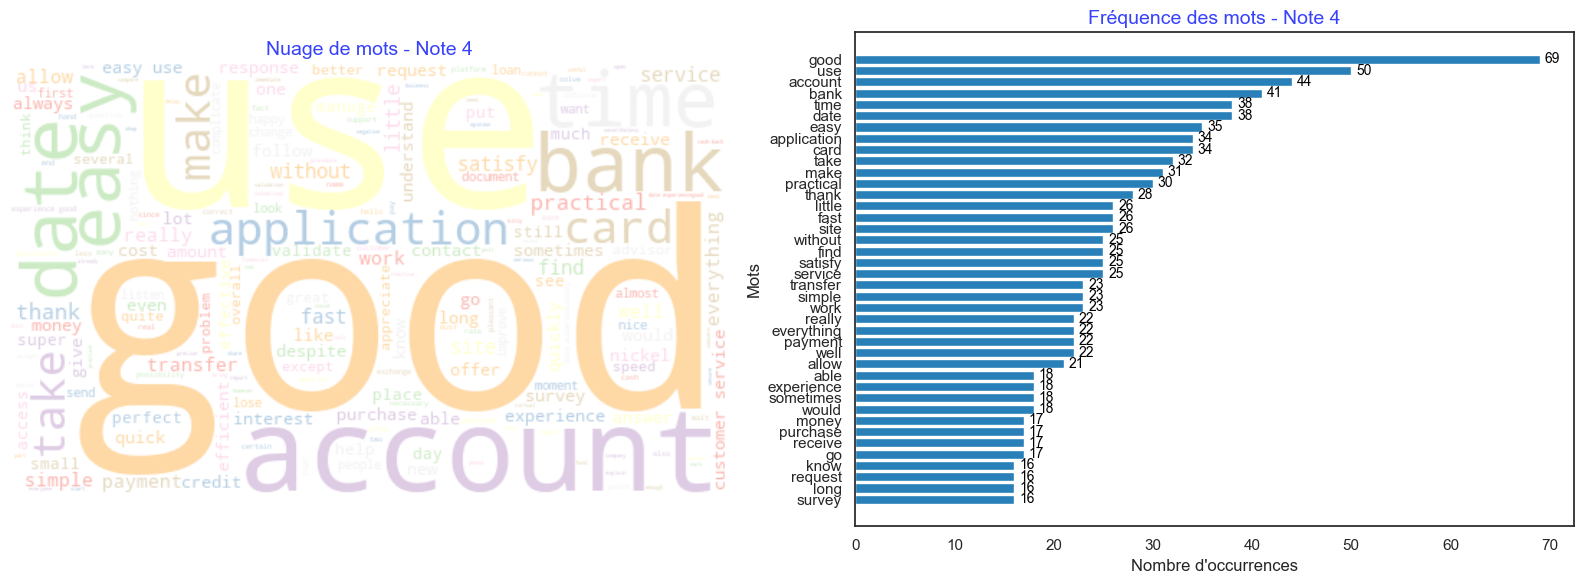

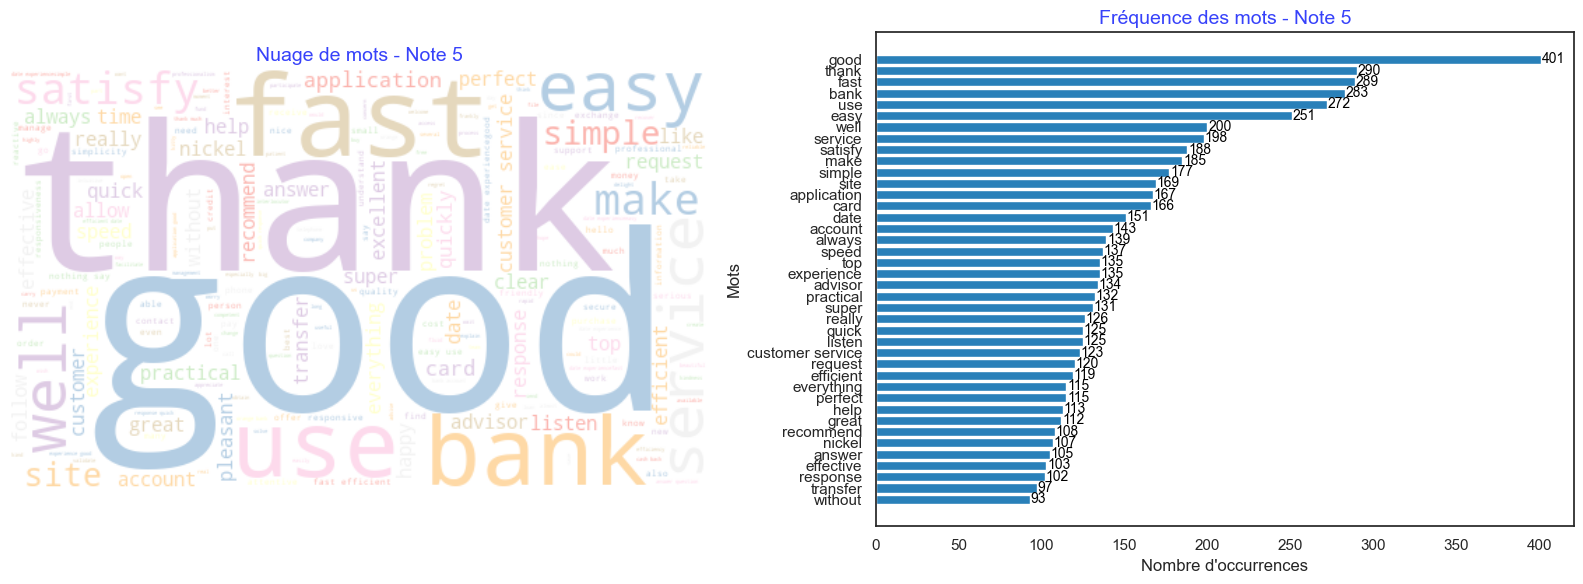

In [33]:
# Afficher le nuage de mots et les fréquences pour un texte spécifique
df1 = afficher_wordcloud_et_frequence(text1, "Note 1")
df2 = afficher_wordcloud_et_frequence(text2, "Note 2")
df3 = afficher_wordcloud_et_frequence(text3, "Note 3")
df4 = afficher_wordcloud_et_frequence(text4, "Note 4")
df5 = afficher_wordcloud_et_frequence(text5, "Note 5")

In [34]:
# Créer une liste contenant tous les DataFrames
dfs = [df1, df2, df3, df4, df5]
#on ajoute la colone rating
df1['rating'] = 1
df2['rating'] = 2
df3['rating'] = 3
df4['rating'] = 4
df5['rating'] = 5

# Utiliser pd.concat pour concaténer les DataFrames
df_result = pd.concat(dfs, ignore_index=True)

# Afficher le DataFrame résultant
df_result

,Mot,Fréquence,rating
0,account,159,1
1,bank,157,1
2,make,145,1
3,ask,111,1
4,take,107,1
...,...,...,...
195,answer,105,5
196,effective,103,5
197,response,102,5
198,transfer,97,5


In [35]:
df

,cat_response,commentaire_text,positive_emojis,negative_emojis,sentiment,num_special_characters,num_uppercase_characters,total_characters,nombre_point_exclam,nombre_point_intero,char_bins,rating,diff_experience_review,diff_review_response,commentaire_clean,sentiment_commentaire,commentaire_clean_pos_tag,commentaire_en_sans_SW
0,0,MERCI Bonjour je mets 5 étoiles car j'ai eu to...,0,0,Positif,7,7,329,1,0,Très Long,5,6,42,thank hello put star help need customer servic...,1,thank_NN hello_NN put_VBD star_NN help_NN need...,thank hello put star help need customer servic...
1,0,"Rapide , simple et efficace Très accessible , ...",0,0,Positif,9,4,289,0,0,Très Long,5,8,43,simple efficient answer fill different attach ...,1,simple_JJ efficient_JJ answer_NN fill_NN diffe...,simple efficient answer fill different attach ...
2,0,Réponse ultra rapide et surtout Réponse ultra ...,0,0,Positif,9,5,330,0,0,Très Long,5,7,47,ultra fast response especially ultra fast acce...,1,ultra_JJ fast_JJ response_NN especially_RB ult...,ultra fast response especially ultra fast acce...
3,0,Rapport service client au top Rapport service ...,0,0,Positif,6,4,177,0,0,Très Long,5,8,42,customer service report top customer service r...,1,customer_NN service_NN report_NN top_JJ custom...,customer service report top customer service r...
4,0,Elle m'a permise de réaliser mon projet Elle m...,0,0,Positif,3,2,149,0,0,Très Long,5,5,42,allow carry allow carry project easy request s...,1,allow_JJ carry_NN allow_VB carry_NN project_NN...,allow carry allow carry project easy request s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,1,Pourri Pourri. Tjrs des bugs sur les applicati...,0,0,Négatif,3,6,164,0,0,Très Long,1,0,0,rotten always bug buy via competitor feed site...,0,rotten_NN always_RB bug_JJ buy_NN via_IN compe...,rotten always bug buy via competitor feed site...
5500,1,Un contact après un long silence de ma Un cont...,0,0,Positif,4,3,186,0,0,Très Long,5,0,0,contact long silence contact long silence good...,1,contact_NN long_JJ silence_NN contact_NN long_...,contact long silence contact long silence good...
5501,1,Je dois être bête je n ai rien compris Je dois...,0,0,Neutre,7,9,371,0,3,Très Long,3,4,0,must silly understand anything must silly unde...,1,must_MD silly_RB understand_VB anything_NN mus...,must silly understand anything must silly unde...
5502,1,Application correcte et pour le coup Applicati...,0,0,Positif,3,2,152,0,0,Très Long,5,22,1,correct application timely application correct...,1,correct_JJ application_NN timely_JJ applicatio...,correct application timely application correct...


In [36]:
# Créer les dummies pour les notes (rating) de 1 à 5
df_result_dummies = pd.get_dummies(df_result['rating'], prefix='rating')

# Ajouter ces dummies au DataFrame principal
df_result = pd.concat([df_result, df_result_dummies], axis=1)

# Assurer que les colonnes dummies sont au format float
for i in range(1, 6):
    note_col = f'rating_{i}'
    if note_col in df_result.columns:
        df_result[note_col] = df_result[note_col].astype('float')

# Si tu veux créer une nouvelle colonne qui est la somme de toutes les dummies de note (note_1 à note_5)
df_result['rating_sum'] = df_result[['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']].sum(axis=1)

# Afficher les informations du DataFrame après ajout des dummies et de la somme
df_result.info()

# Afficher les premières lignes du DataFrame pour vérifier
df_result.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Mot         200 non-null    object 
 1   Fréquence   200 non-null    int64  
 2   rating      200 non-null    int64  
 3   rating_1    200 non-null    float64
 4   rating_2    200 non-null    float64
 5   rating_3    200 non-null    float64
 6   rating_4    200 non-null    float64
 7   rating_5    200 non-null    float64
 8   rating_sum  200 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 14.2+ KB


,Mot,Fréquence,rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_sum
0,account,159,1,1.0,0.0,0.0,0.0,0.0,1.0
1,bank,157,1,1.0,0.0,0.0,0.0,0.0,1.0
2,make,145,1,1.0,0.0,0.0,0.0,0.0,1.0
3,ask,111,1,1.0,0.0,0.0,0.0,0.0,1.0
4,take,107,1,1.0,0.0,0.0,0.0,0.0,1.0


In [37]:
df_result.describe()

,Fréquence,rating,rating_1,rating_2,rating_3,rating_4,rating_5,rating_sum
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0
mean,58.510000,3.000000,0.200000,0.200000,0.200000,0.200000,0.200000,1.0
std,64.748061,1.417762,0.401004,0.401004,0.401004,0.401004,0.401004,0.0
min,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,14.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,26.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,88.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,401.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [38]:
## il faut faire un pivote table par mot:
pivot_table = pd.pivot_table(df_result, values='rating_sum', columns='Mot' , aggfunc='sum', fill_value=0)
# pivot_table = pd.pivot_table(df_result, values='Mot', columns='rating_sum' , aggfunc='sum', fill_value=0)
display(pivot_table)
grouped_df = df_result.groupby(['Mot', 'rating_sum']).agg({'Fréquence': 'sum'}).reset_index()
grouped_df

Mot,able,account,advisor,allow,always,answer,application,ask,back,bank,...,transfer,understand,use,validate,wait,want,well,without,work,would
rating_sum,1.0,5.0,1.0,1.0,2.0,2.0,3.0,2.0,1.0,5.0,...,5.0,1.0,5.0,2.0,2.0,1.0,4.0,5.0,4.0,2.0


,Mot,rating_sum,Fréquence
0,able,1.0,18
1,account,1.0,394
2,advisor,1.0,134
3,allow,1.0,21
4,always,1.0,149
...,...,...,...
90,want,1.0,56
91,well,1.0,245
92,without,1.0,231
93,work,1.0,111


In [39]:
print(grouped_df['rating_sum'].unique())
grouped_df.describe()

[1.]


,rating_sum,Fréquence
count,95.0,95.000000
mean,1.0,123.178947
std,0.0,112.632048
min,1.0,9.000000
25%,1.0,32.000000
50%,1.0,102.000000
75%,1.0,166.500000
max,1.0,520.000000


In [40]:
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
df_p = df[0:1000]


count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(df_p["commentaire_clean"])
# print(bag_of_words)

### trouver les mots uniques
feature_names = count_vectorizer.get_feature_names_out()
print(len(feature_names))
print(feature_names)
# df_p.head()

1086
['ability' 'able' 'absolute' ... 'yes' 'young' 'zero']


In [42]:
# Regrouper les mots par catégorie dans un dictionnaire
words_by_category = df_p.groupby('rating')['commentaire_clean'].apply(set).to_dict()

# Obtenir l'intersection des ensembles de mots
common_words = set.intersection(*words_by_category.values())

# Afficher les mots communs
print(common_words)
# words_by_category

set()


In [43]:
## parcourir tous les mots et identifier ceux qui apparaissent sur toutes les notes
categories = {
    1: ['mot1', 'mot2', 'mot3', 'mot4'],
    2: ['mot2', 'mot3', 'mot5', 'mot6'],
    3: ['mot1', 'mot3', 'mot5', 'mot7'],
    4: ['mot2', 'mot3', 'mot7', 'mot8'],
    5: ['mot1', 'mot3', 'mot5', 'mot8']
}

# Créer des ensembles pour chaque catégorie
sets_by_category = {category: set(words) for category, words in categories.items()}

# Trouver l'intersection des ensembles
common_words = set.intersection(*sets_by_category.values())

# Afficher les mots communs
print(common_words)

{'mot3'}


In [44]:
## création d'un dataframe avec les données et une colonne par mot unique
show_features_df = pd.DataFrame.from_dict({feature_name: bag_of_words.toarray()[:, c] for c, feature_name in enumerate(feature_names)})
show_features_df

,ability,able,absolute,abuse,accept,acceptance,access,accessible,accommodate,accompaniment,...,worry,worse,worst,would,write,wrong,year,yes,young,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
## concatenner le show_features_df avec notre df dans un nouveau dataframe : result
df_p = df_p.reset_index(drop=True)
print('dimension df de base:' ,df_p.shape)

show_features_df = show_features_df.reset_index(drop=True)
print('dimension features_df:' ,show_features_df.shape)

result = pd.concat([df_p, show_features_df], axis=1)
# result = result.reset_index(drop=True)
print('dimension de nouveau df result:' ,result.shape)
result.head()


dimension df de base: (1000, 18)
dimension features_df: (1000, 1086)
dimension de nouveau df result: (1000, 1104)


,cat_response,commentaire_text,positive_emojis,negative_emojis,sentiment,num_special_characters,num_uppercase_characters,total_characters,nombre_point_exclam,nombre_point_intero,...,worry,worse,worst,would,write,wrong,year,yes,young,zero
0,0,MERCI Bonjour je mets 5 étoiles car j'ai eu to...,0,0,Positif,7,7,329,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,"Rapide , simple et efficace Très accessible , ...",0,0,Positif,9,4,289,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,Réponse ultra rapide et surtout Réponse ultra ...,0,0,Positif,9,5,330,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,Rapport service client au top Rapport service ...,0,0,Positif,6,4,177,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,Elle m'a permise de réaliser mon projet Elle m...,0,0,Positif,3,2,149,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Modélisations et Tests des algorithmes ML**

In [46]:
# Charger le fichier JSON dans un DataFrame
df = pd.read_json("data_prep.json")

# Afficher les 5 premières lignes pour vérifier
df.head()

,cat_response,commentaire_text,positive_emojis,negative_emojis,sentiment,num_special_characters,num_uppercase_characters,total_characters,nombre_point_exclam,nombre_point_intero,char_bins,rating,diff_experience_review,diff_review_response,commentaire_clean,sentiment_commentaire,commentaire_clean_pos_tag
0,0,MERCI Bonjour je mets 5 étoiles car j'ai eu to...,0,0,Positif,7,7,329,1,0,Très Long,5,6,42,thank hello put star help need customer servic...,1,thank_NN hello_NN put_VBD star_NN help_NN need...
1,0,"Rapide , simple et efficace Très accessible , ...",0,0,Positif,9,4,289,0,0,Très Long,5,8,43,simple efficient answer fill different attach ...,1,simple_JJ efficient_JJ answer_NN fill_NN diffe...
2,0,Réponse ultra rapide et surtout Réponse ultra ...,0,0,Positif,9,5,330,0,0,Très Long,5,7,47,ultra fast response especially ultra fast acce...,1,ultra_JJ fast_JJ response_NN especially_RB ult...
3,0,Rapport service client au top Rapport service ...,0,0,Positif,6,4,177,0,0,Très Long,5,8,42,customer service report top customer service r...,1,customer_NN service_NN report_NN top_JJ custom...
4,0,Elle m'a permise de réaliser mon projet Elle m...,0,0,Positif,3,2,149,0,0,Très Long,5,5,42,allow carry allow carry project easy request s...,1,allow_JJ carry_NN allow_VB carry_NN project_NN...


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   cat_response               5479 non-null   int64 
 1   commentaire_text           5479 non-null   object
 2   positive_emojis            5479 non-null   int64 
 3   negative_emojis            5479 non-null   int64 
 4   sentiment                  5479 non-null   object
 5   num_special_characters     5479 non-null   int64 
 6   num_uppercase_characters   5479 non-null   int64 
 7   total_characters           5479 non-null   int64 
 8   nombre_point_exclam        5479 non-null   int64 
 9   nombre_point_intero        5479 non-null   int64 
 10  char_bins                  5479 non-null   object
 11  rating                     5479 non-null   int64 
 12  diff_experience_review     5479 non-null   int64 
 13  diff_review_response       5479 non-null   int64 
 14  commenta

In [48]:
# Importation des bibliothèques nécessaires
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [49]:
col_delete = ['commentaire_text', 'sentiment', 'char_bins']
df = df.drop(columns=col_delete)

In [50]:
# Copier le DataFrame pour éviter toute modification accidentelle
data = df.copy()

# Séparation des variables explicatives (X) et de la variable cible (y)
X = data.drop(columns=["rating"])  # Variables explicatives (toutes les colonnes sauf 'rating')
y = data["rating"]  # Variable cible (rating)

# Vérification des colonnes de X pour être sûr que tout est en ordre
print("Columns in X:", X.columns)

Columns in X: Index(['cat_response', 'positive_emojis', 'negative_emojis',
       'num_special_characters', 'num_uppercase_characters',
       'total_characters', 'nombre_point_exclam', 'nombre_point_intero',
       'diff_experience_review', 'diff_review_response', 'commentaire_clean',
       'sentiment_commentaire', 'commentaire_clean_pos_tag'],
      dtype='object')


In [62]:
from sklearn.impute import SimpleImputer

In [63]:
# Définir les colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Créer les transformateurs
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Remplir les valeurs manquantes
    ('scaler', StandardScaler())  # Appliquer le scaling
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Remplir les valeurs manquantes
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Appliquer l'encodage OneHot
])

In [64]:
# Combiner les transformateurs dans un seul préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [65]:
# Appliquer le préprocesseur pour transformer les données d'entraînement et de test
X_train_transformed = preprocessor.fit_transform(X_train)  # Transformation de l'ensemble d'entraînement
X_test_transformed = preprocessor.transform(X_test)  # Transformation de l'ensemble de test

# Vérification de la forme des données transformées
print(f"Shape of transformed X_train: {X_train_transformed.shape}")
print(f"Shape of transformed X_test: {X_test_transformed.shape}")

# X_train_transformed et X_test_transformed sont maintenant prêts pour l'entraînement du modèle

Shape of transformed X_train: (4383, 8209)
Shape of transformed X_test: (1096, 8209)


## KNN et RAndomforest

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

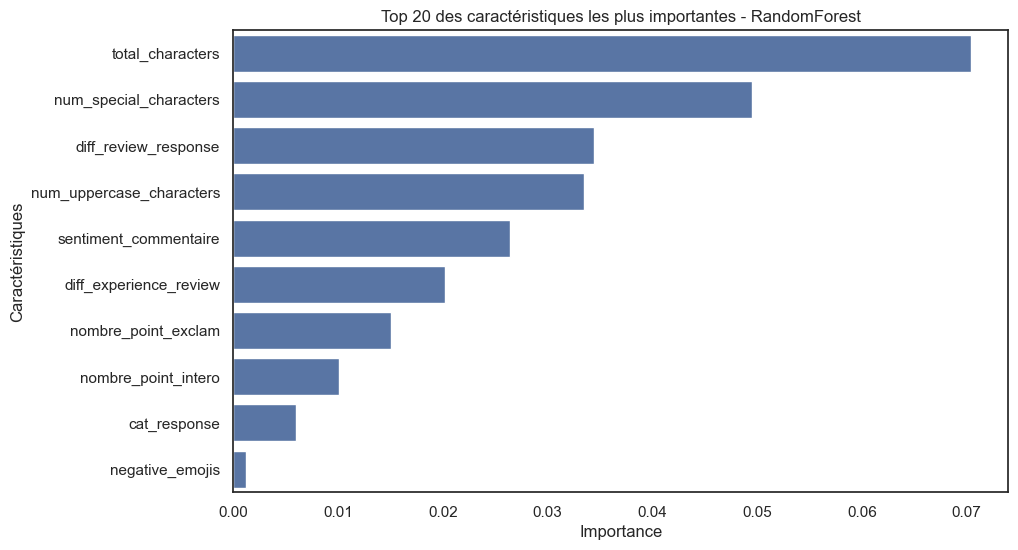

In [55]:
# Créer les modèles
modele_rf = RandomForestClassifier(random_state=42)
modele_knn = KNeighborsClassifier()

# Entraîner les modèles sur les données transformées
modele_rf.fit(X_train_transformed, y_train)
joblib.dump(modele_rf, "models/modele_rf_lib")

modele_knn.fit(X_train_transformed, y_train)
joblib.dump(modele_knn, "models/modele_knn_lib")

# Visualisation de l'importance des caractéristiques du modèle RandomForest
# Nous devons récupérer les noms des caractéristiques après transformation, y compris celles générées par OneHotEncoder
# Cela se fait via le `ColumnTransformer` utilisé dans le préprocesseur

# Pour les variables numériques, on garde les noms d'origine
numeric_column_names = numeric_features

# Pour les variables catégorielles, on récupère les noms après OneHotEncoding
categorical_column_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)

# Combiner les noms des caractéristiques
all_column_names = np.concatenate([numeric_column_names, categorical_column_names])

# Trier les importances des caractéristiques dans l'ordre décroissant
importances = modele_rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Indices triés par importance décroissante

# Sélectionner les 10 premières caractéristiques
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_column_names = all_column_names[top_indices]

# Visualiser les 20 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_column_names)  # Utiliser les noms des colonnes transformées
plt.title("Top 20 des caractéristiques les plus importantes - RandomForest")
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.show()

  File "c:\Users\mbouc\supply_sentiment - Copie\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Prédictions RandomForest (exemples) :  [5 5 5 5 5]
Prédictions KNN (exemples) :  [5 5 5 5 5]


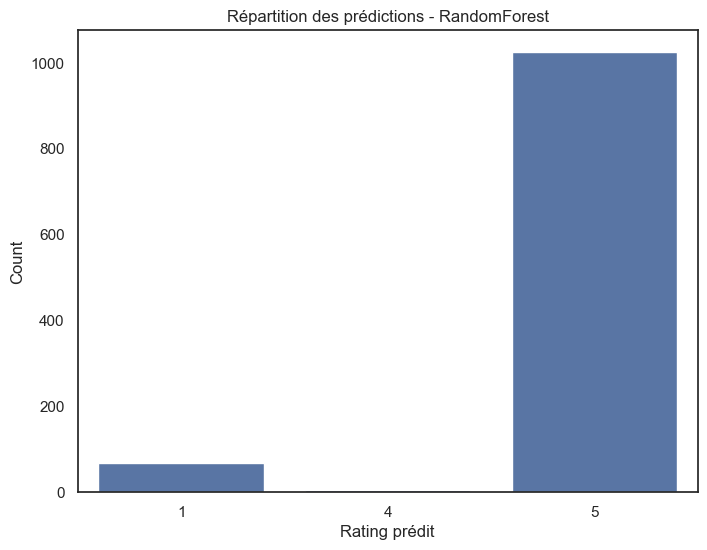

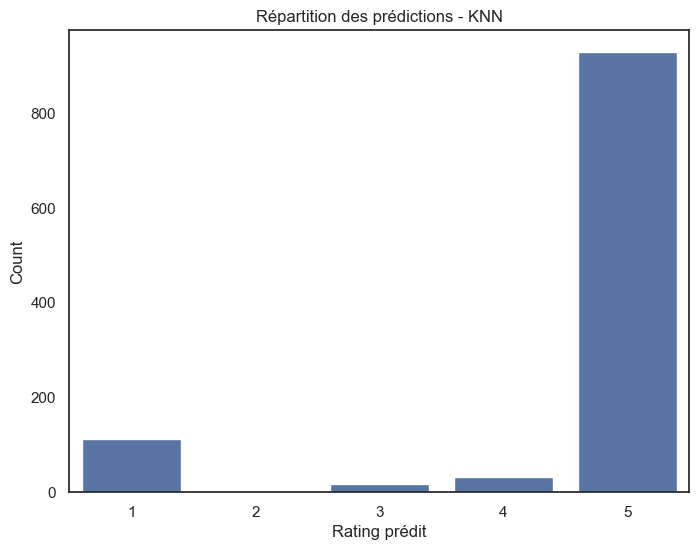

In [56]:
# Prédictions avec le modèle RandomForest et KNN
y_predict_rf = modele_rf.predict(X_test_transformed)
y_predict_knn = modele_knn.predict(X_test_transformed)

# Affichage des premières prédictions
print("Prédictions RandomForest (exemples) : ", y_predict_rf[:5])
print("Prédictions KNN (exemples) : ", y_predict_knn[:5])

# Visualisation des prédictions sur l'ensemble de test
plt.figure(figsize=(8, 6))
sns.countplot(x=y_predict_rf)
plt.title("Répartition des prédictions - RandomForest")
plt.xlabel('Rating prédit')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_predict_knn)
plt.title("Répartition des prédictions - KNN")
plt.xlabel('Rating prédit')
plt.ylabel('Count')
plt.show()


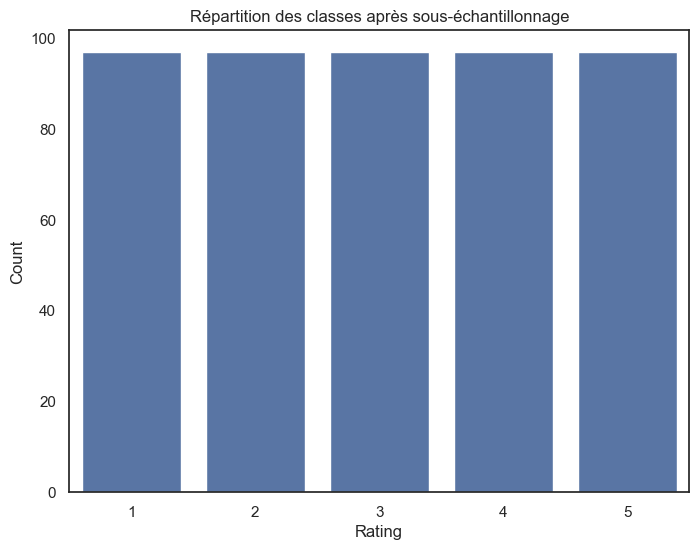

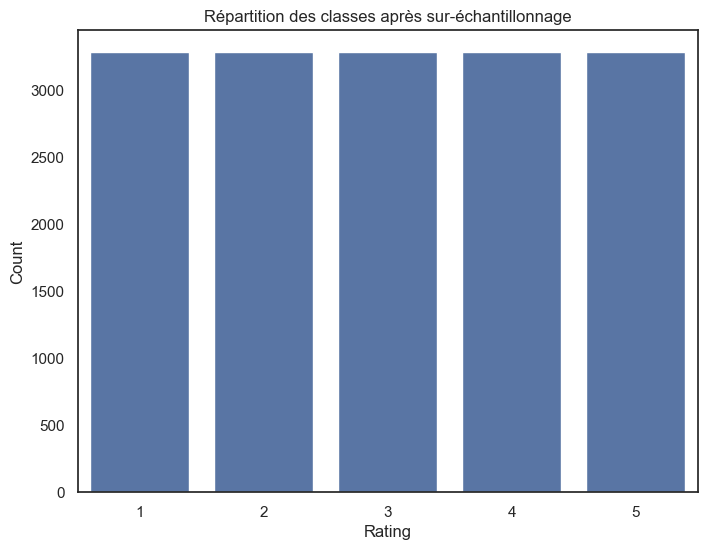

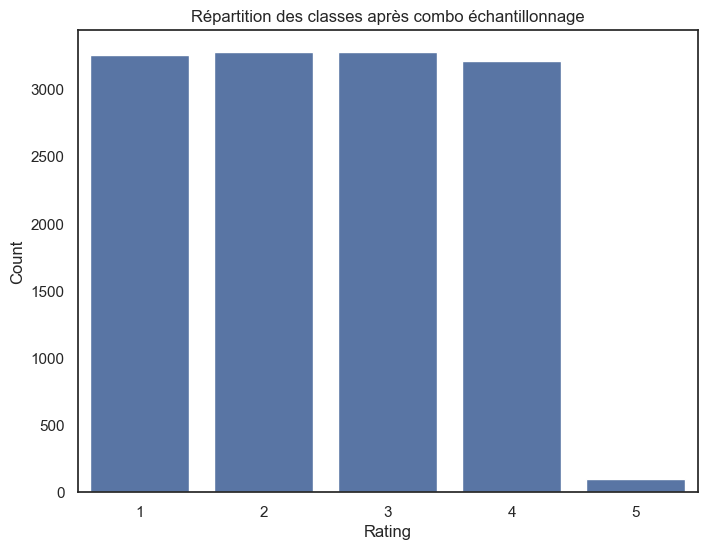

In [57]:
#Sous-échantillonnage avec NearMiss
ss_echant = NearMiss()
x_sous, y_sous = ss_echant.fit_resample(X_train_transformed, y_train)

# Visualisation de la répartition des classes après sous-échantillonnage
plt.figure(figsize=(8, 6))
sns.countplot(x=y_sous)
plt.title("Répartition des classes après sous-échantillonnage")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Sur-échantillonnage avec SMOTE
sur_echant = SMOTE()
x_sur, y_sur = sur_echant.fit_resample(X_train_transformed, y_train)

# Visualisation de la répartition des classes après sur-échantillonnage
plt.figure(figsize=(8, 6))
sns.countplot(x=y_sur)
plt.title("Répartition des classes après sur-échantillonnage")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Combo échantillonnage avec SMOTEENN
comb_echant = SMOTEENN()
x_comb, y_comb = comb_echant.fit_resample(X_train_transformed, y_train)

# Visualisation de la répartition des classes après combo échantillonnage
plt.figure(figsize=(8, 6))
sns.countplot(x=y_comb)
plt.title("Répartition des classes après combo échantillonnage")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [58]:
# Entraînement des modèles sur les données sous-échantillonnées
modele_rf_sous = RandomForestClassifier(random_state=42)
modele_rf_sous.fit(x_sous, y_sous)
joblib.dump(modele_rf_sous, "models/modele_rf_sous_lib")

modele_knn_sous = KNeighborsClassifier()
modele_knn_sous.fit(x_sous, y_sous)
joblib.dump(modele_knn_sous, "models/modele_knn_sous_lib")

# Entraînement des modèles sur les données sur-échantillonnées
modele_rf_sur = RandomForestClassifier(random_state=42)
modele_rf_sur.fit(x_sur, y_sur)
joblib.dump(modele_rf_sur, "models/modele_rf_sur_lib")

modele_knn_sur = KNeighborsClassifier()
modele_knn_sur.fit(x_sur, y_sur)
joblib.dump(modele_knn_sur, "models/modele_knn_sur_lib")

# Entraînement des modèles sur les données combinées
modele_rf_comb = RandomForestClassifier(random_state=42)
modele_rf_comb.fit(x_comb, y_comb)
joblib.dump(modele_rf_comb, "models/modele_rf_comb_lib")

modele_knn_comb = KNeighborsClassifier()
modele_knn_comb.fit(x_comb, y_comb)
joblib.dump(modele_knn_comb, "models/modele_knn_comb_lib")


['models/modele_knn_comb_lib']

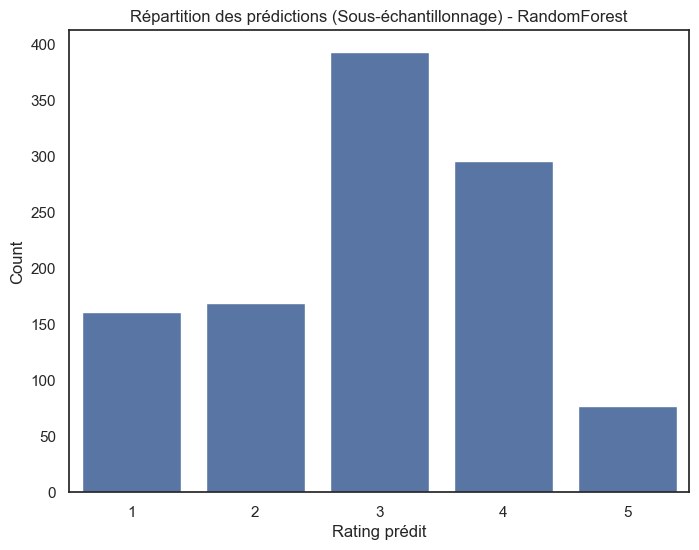

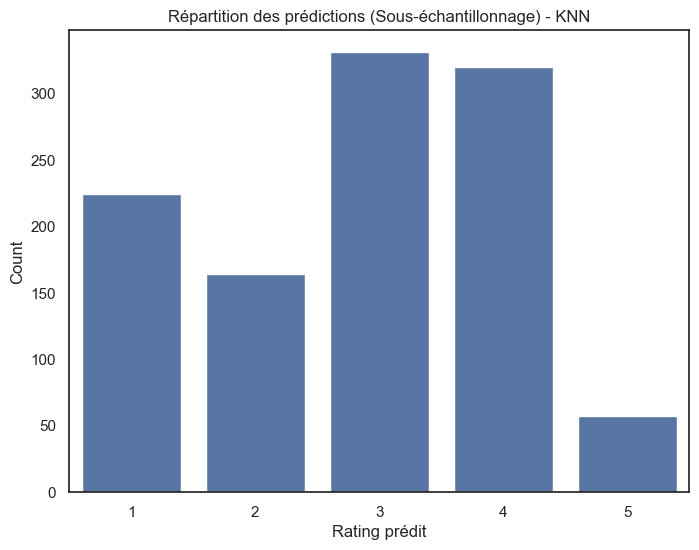

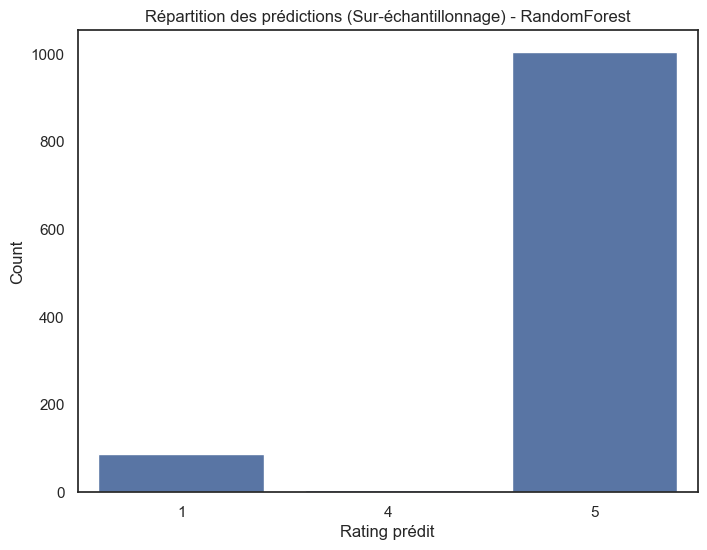

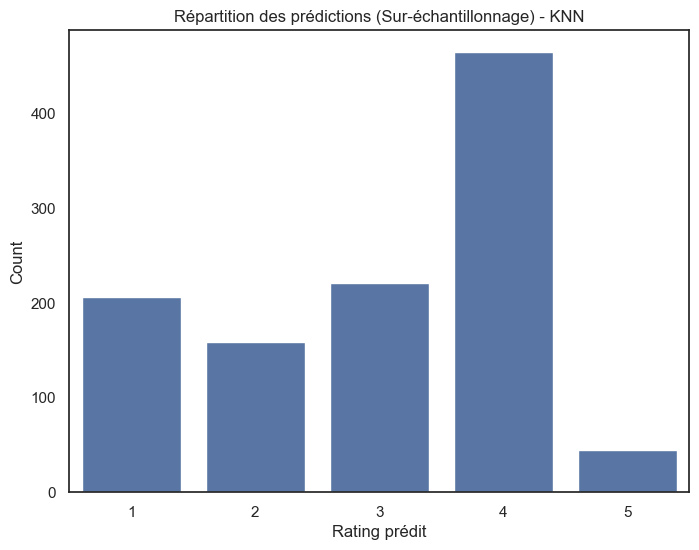

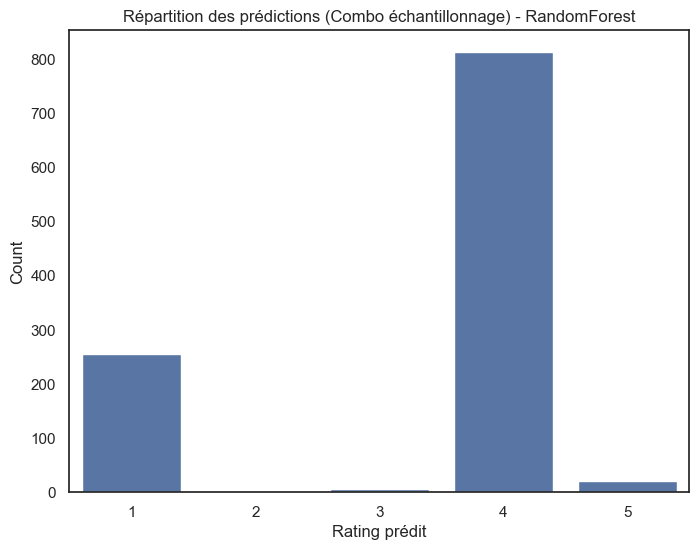

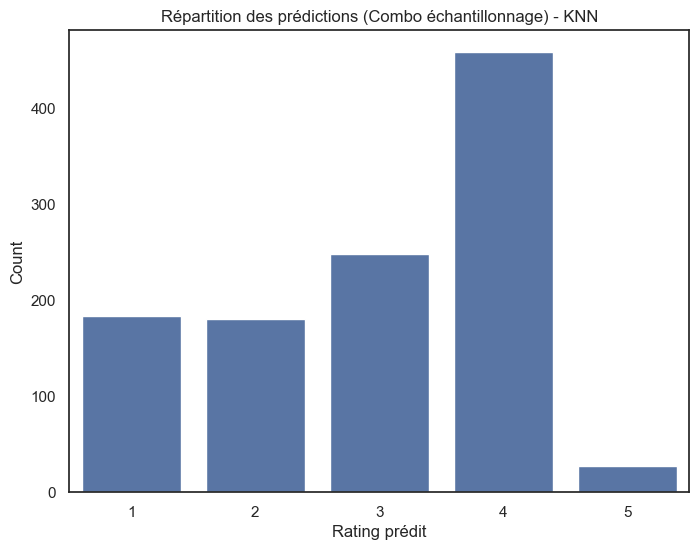

In [67]:
# Prédictions avec les modèles entraînés sur les données sous-échantillonnées
y_predict_rf_sous = modele_rf_sous.predict(X_test_transformed)
y_predict_knn_sous = modele_knn_sous.predict(X_test_transformed)

# Prédictions avec les modèles entraînés sur les données sur-échantillonnées
y_predict_rf_sur = modele_rf_sur.predict(X_test_transformed)
y_predict_knn_sur = modele_knn_sur.predict(X_test_transformed)

# Prédictions avec les modèles entraînés sur les données combinées
y_predict_rf_comb = modele_rf_comb.predict(X_test_transformed)
y_predict_knn_comb = modele_knn_comb.predict(X_test_transformed)

# Visualisation des prédictions pour chaque échantillonnage
plt.figure(figsize=(8, 6))
sns.countplot(x=y_predict_rf_sous)
plt.title("Répartition des prédictions (Sous-échantillonnage) - RandomForest")
plt.xlabel('Rating prédit')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_predict_knn_sous)
plt.title("Répartition des prédictions (Sous-échantillonnage) - KNN")
plt.xlabel('Rating prédit')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_predict_rf_sur)
plt.title("Répartition des prédictions (Sur-échantillonnage) - RandomForest")
plt.xlabel('Rating prédit')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_predict_knn_sur)
plt.title("Répartition des prédictions (Sur-échantillonnage) - KNN")
plt.xlabel('Rating prédit')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_predict_rf_comb)
plt.title("Répartition des prédictions (Combo échantillonnage) - RandomForest")
plt.xlabel('Rating prédit')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_predict_knn_comb)
plt.title("Répartition des prédictions (Combo échantillonnage) - KNN")
plt.xlabel('Rating prédit')
plt.ylabel('Count')
plt.show()


In [79]:
from sklearn.metrics import  confusion_matrix, classification_report, mean_squared_error,accuracy_score, f1_score, roc_auc_score, roc_curve, auc

In [70]:
# Évaluation du modèle RandomForest sur les données originales
print("Évaluation RandomForest (original) :")
print(classification_report(y_test, y_predict_rf))  # Ajoutez y_test et y_predict_rf

# Évaluation du modèle KNN sur les données originales
print("Évaluation KNN (original) :")
print(classification_report(y_test, y_predict_knn))  # Ajoutez y_test et y_predict_knn

# Évaluation des modèles avec les données sous-échantillonnées
print("Évaluation RandomForest (Sous-échantillonnage) :")
print(classification_report(y_test, y_predict_rf_sous))  # Ajoutez y_test et y_predict_rf_sous

print("Évaluation KNN (Sous-échantillonnage) :")
print(classification_report(y_test, y_predict_knn_sous))  # Ajoutez y_test et y_predict_knn_sous

# Évaluation des modèles avec les données sur-échantillonnées
print("Évaluation RandomForest (Sur-échantillonnage) :")
print(classification_report(y_test, y_predict_rf_sur))  # Ajoutez y_test et y_predict_rf_sur

print("Évaluation KNN (Sur-échantillonnage) :")
print(classification_report(y_test, y_predict_knn_sur))  # Ajoutez y_test et y_predict_knn_sur

# Évaluation des modèles avec les données combinées
print("Évaluation RandomForest (Combo échantillonnage) :")
print(classification_report(y_test, y_predict_rf_comb))  # Ajoutez y_test et y_predict_rf_comb

print("Évaluation KNN (Combo échantillonnage) :")
print(classification_report(y_test, y_predict_knn_comb))  # Ajoutez y_test et y_predict_knn_comb


Évaluation RandomForest (original) :
              precision    recall  f1-score   support

           1       0.66      0.44      0.53        99
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00        95
           5       0.80      0.98      0.88       838

    accuracy                           0.79      1096
   macro avg       0.29      0.29      0.28      1096
weighted avg       0.67      0.79      0.72      1096

Évaluation KNN (original) :
              precision    recall  f1-score   support

           1       0.47      0.54      0.50        99
           2       0.00      0.00      0.00        24
           3       0.06      0.03      0.03        40
           4       0.12      0.04      0.06        95
           5       0.83      0.92      0.87       838

    accuracy                           0.75      1096
   macro avg       0.29      0.30      0.29      1096
weighted avg

### Résumé de l'Interprétation des Résultats des Modèles

#### 1. **Performance du modèle sur les données originales** :
   - **RandomForest** : 
     - Bon score global (précision = 0.79), mais faible performance pour les classes minoritaires (1, 2, 3, 4).
     - La classe 5 (dominante) obtient un excellent F1-score de 0.88.
   - **KNN** : 
     - Précision de 0.75, avec de bons résultats pour la classe 5 (F1-score = 0.87), mais faible pour les autres classes.

#### 2. **Sous-échantillonnage** :
   - Les modèles montrent des performances très faibles avec une précision et un F1-score globalement bas.
   - Le sous-échantillonnage a un impact négatif, en particulier sur la capacité des modèles à prédire les classes minoritaires.
   - La classe 5, malgré sa grande majorité, est mal prédite dans les deux modèles (F1-score = 0.14).

#### 3. **Sur-échantillonnage** :
   - **RandomForest** : 
     - Résultats similaires aux données originales, avec de bons scores pour la classe 5 (F1-score = 0.88), mais faibles pour les autres classes.
   - **KNN** : 
     - Faibles performances, surtout pour les classes minoritaires.

#### 4. **Combo échantillonnage (sur-échantillonnage + sous-échantillonnage)** :
   - Les performances des modèles sont très faibles avec une précision et un F1-score faibles pour toutes les classes.
   - La combinaison des deux stratégies d’échantillonnage semble avoir un impact négatif sur la performance des modèles.

### Recommandations et Prochaines Étapes :
- **Stratégie d'échantillonnage** : 
  - Le **sur-échantillonnage** donne de meilleurs résultats que le sous-échantillonnage et la combinaison des deux
  
- **Révision des modèles** :
  - Tester des réglages d'hyperparamètres via **GridSearchCV** ou **RandomizedSearchCV** pour améliorer les performances des modèles.
  - Tester d'autres modèles comme **XGBoost** ou **LightGBM** pour des problèmes de classification déséquilibrée.

- **Métriques d'évaluation** :
  - Utiliser des métriques adaptées aux classes déséquilibrées comme **AUC-ROC**, **précision-macro**, ou **F1-score** pour mieux évaluer les performances, surtout sur les classes minoritaires.

### Conclusion :
En résumé, pour améliorer les performances, il est recommandé d'explorer des techniques d'échantillonnage avancées, d'optimiser les hyperparamètres et d'utiliser des modèles plus robustes pour les classes déséquilibrées.


In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [83]:
# Initialiser un DataFrame pour stocker les résultats
results_models = pd.DataFrame(columns=['Modèle', 'Score', 'Précision', 'Rappel', 'F1'])

# Fonction pour calculer les métriques de performance
def calculate_metrics(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return score, precision, recall, f1

# Boucle sur chaque modèle et évaluation des performances
for model_name, model in zip(['Random Forest', 'KNN'], [modele_rf, modele_knn]):
    # Faire des prédictions sur les données de test transformées
    y_pred = model.predict(X_test_transformed)
    
    # Calcul des métriques
    score, precision, recall, f1 = calculate_metrics(y_test, y_pred)
    
    # Affichage des résultats
    print(f"{model_name} :")
    print(f"Score: {round(score, 4)} | Précision: {round(precision, 4)} | Rappel: {round(recall, 4)} | F1: {round(f1, 4)}\n")
    
    # Créer un DataFrame pour les résultats du modèle actuel
    model_results = pd.DataFrame([{
        'Modèle': model_name,
        'Score': round(score, 4),
        'Précision': round(precision, 4),
        'Rappel': round(recall, 4),
        'F1': round(f1, 4)
    }])
    
    # Ajouter les résultats au DataFrame principal en utilisant pd.concat()
    results_models = pd.concat([results_models, model_results], ignore_index=True)

# Afficher les résultats dans un DataFrame
print("Résultats des modèles :\n")
results_models

Random Forest :
Score: 0.792 | Précision: 0.674 | Rappel: 0.792 | F1: 0.7242

KNN :
Score: 0.7536 | Précision: 0.687 | Rappel: 0.7536 | F1: 0.7165

Résultats des modèles :



,Modèle,Score,Précision,Rappel,F1
0,Random Forest,0.7920,0.674,0.7920,0.7242
1,KNN,0.7536,0.687,0.7536,0.7165


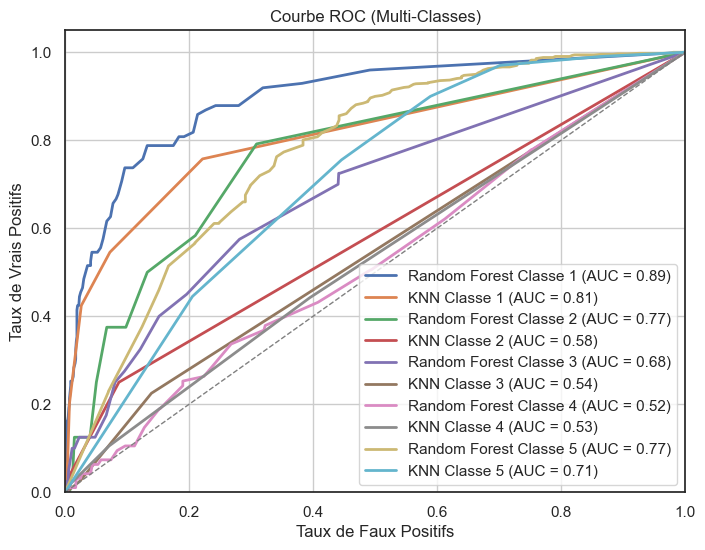

In [87]:
# Convertir les labels des classes en format binaire (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])  # Adaptez les classes selon votre cas

# Obtenez les probabilités prédites pour chaque classe
rf_probs = modele_rf.predict_proba(X_test_transformed)
knn_probs = modele_knn.predict_proba(X_test_transformed)

# Calculer la courbe ROC et l'AUC pour chaque classe
rf_fpr, rf_tpr, rf_auc = {}, {}, {}
knn_fpr, knn_tpr, knn_auc = {}, {}, {}

for i in range(rf_probs.shape[1]):
    # Random Forest
    rf_fpr[i], rf_tpr[i], _ = roc_curve(y_test_bin[:, i], rf_probs[:, i])
    rf_auc[i] = auc(rf_fpr[i], rf_tpr[i])

    # KNN
    knn_fpr[i], knn_tpr[i], _ = roc_curve(y_test_bin[:, i], knn_probs[:, i])
    knn_auc[i] = auc(knn_fpr[i], knn_tpr[i])

# Tracer la courbe ROC pour chaque classe
plt.figure(figsize=(8, 6))

# Tracer la courbe ROC pour chaque classe
for i in range(rf_probs.shape[1]):
    plt.plot(rf_fpr[i], rf_tpr[i], lw=2, label=f'Random Forest Classe {i+1} (AUC = {rf_auc[i]:.2f})')
    plt.plot(knn_fpr[i], knn_tpr[i], lw=2, label=f'KNN Classe {i+1} (AUC = {knn_auc[i]:.2f})')

# Tracer la ligne de chance
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC (Multi-Classes)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

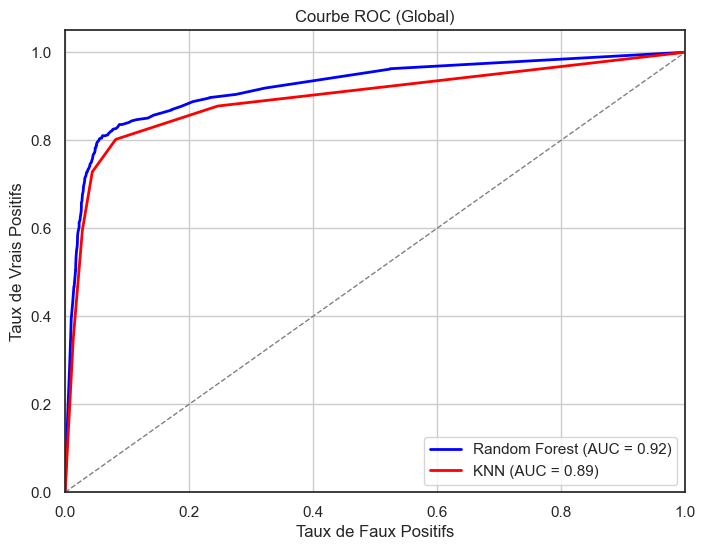

In [88]:
# Convertir les labels des classes en format binaire (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])  # Adaptez les classes selon votre cas

# Obtenez les probabilités prédites pour chaque classe
rf_probs = modele_rf.predict_proba(X_test_transformed)
knn_probs = modele_knn.predict_proba(X_test_transformed)

# Calculer la courbe ROC et l'AUC globale pour Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test_bin.ravel(), rf_probs.ravel())
rf_auc = auc(rf_fpr, rf_tpr)

# Calculer la courbe ROC et l'AUC globale pour KNN
knn_fpr, knn_tpr, _ = roc_curve(y_test_bin.ravel(), knn_probs.ravel())
knn_auc = auc(knn_fpr, knn_tpr)

# Tracer la courbe ROC globale
plt.figure(figsize=(8, 6))

# Tracer la courbe ROC pour Random Forest
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label=f'Random Forest (AUC = {rf_auc:.2f})')

# Tracer la courbe ROC pour KNN
plt.plot(knn_fpr, knn_tpr, color='red', lw=2, label=f'KNN (AUC = {knn_auc:.2f})')

# Tracer la ligne de chance
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC (Global)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Modélisation avec XGboost

In [106]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [104]:
# 1️⃣ Charger les données (Exemple avec X et y)
# Assurez-vous que X contient vos features et y la cible
print("Distribution avant rééquilibrage :", Counter(y_train))

# 2️⃣ Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(sampling_strategy='auto', random_state=42)  
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

print("Distribution après SMOTE :", Counter(y_train_smote))

Distribution avant rééquilibrage : Counter({5: 3284, 1: 421, 4: 419, 3: 162, 2: 97})
Distribution après SMOTE : Counter({5: 3284, 4: 3284, 2: 3284, 1: 3284, 3: 3284})


In [94]:
# Ajuster les étiquettes cibles pour commencer à 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Définir la grille des hyperparamètres
param_grid = {
    'objective': ['multi:softmax'],  # On se concentre uniquement sur la classification multiclasse ici
    'num_class': [5],  # Nombre de classes pour la classification (1 à 5)
    'max_depth': [5, 4],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [200, 100],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [1, 0.9]
}

# Créer l'objet XGBClassifier
xgb_model = xgb.XGBClassifier()

# Utiliser GridSearchCV pour la recherche par grille
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=3)

# Entraîner le modèle avec GridSearchCV en utilisant les étiquettes ajustées
grid_search.fit(X_train_transformed, y_train_adjusted)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)

# Faire des prédictions avec le meilleur modèle
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_transformed)

# Revenir aux classes d'origine en réajustant les prédictions
predictions_original = predictions + 1

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, predictions_original)
print(f'Précision du modèle : {accuracy * 100:.2f}%')

# Afficher un rapport de classification détaillé
print("Rapport de classification :")
print(classification_report(y_test, predictions_original))

Meilleurs paramètres: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'num_class': 5, 'objective': 'multi:softmax', 'subsample': 0.8}
Précision du modèle : 78.38%
Rapport de classification :
              precision    recall  f1-score   support

           1       0.54      0.53      0.53        99
           2       0.00      0.00      0.00        24
           3       0.14      0.03      0.04        40
           4       0.20      0.02      0.04        95
           5       0.82      0.96      0.88       838

    accuracy                           0.78      1096
   macro avg       0.34      0.31      0.30      1096
weighted avg       0.70      0.78      0.73      1096



In [95]:
# Faire des prédictions avec le meilleur modèle
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_transformed)

# Revenir aux classes d'origine en réajustant les prédictions
predictions_original = predictions + 1

# Calculer la précision du modèle
accuracy = accuracy_score(y_test, predictions_original)
print(f'Précision du modèle : {accuracy * 100:.2f}%')

# Afficher le rapport de classification détaillé
print("\nclassification_report xgboost :\n", classification_report(y_test, predictions_original))

# Matrice de confusion
cm_xgb = confusion_matrix(y_test, predictions_original)
print("\nMatrice de confusion xgboost :\n", cm_xgb)

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, predictions_original)
print(f'Mean Squared Error xgboost: {mse}')

Précision du modèle : 78.38%

classification_report xgboost :
               precision    recall  f1-score   support

           1       0.54      0.53      0.53        99
           2       0.00      0.00      0.00        24
           3       0.14      0.03      0.04        40
           4       0.20      0.02      0.04        95
           5       0.82      0.96      0.88       838

    accuracy                           0.78      1096
   macro avg       0.34      0.31      0.30      1096
weighted avg       0.70      0.78      0.73      1096


Matrice de confusion xgboost :
 [[ 52   0   0   0  47]
 [ 10   0   0   2  12]
 [  9   0   1   0  30]
 [  2   0   1   2  90]
 [ 23   0   5   6 804]]
Mean Squared Error xgboost: 1.4023722627737227


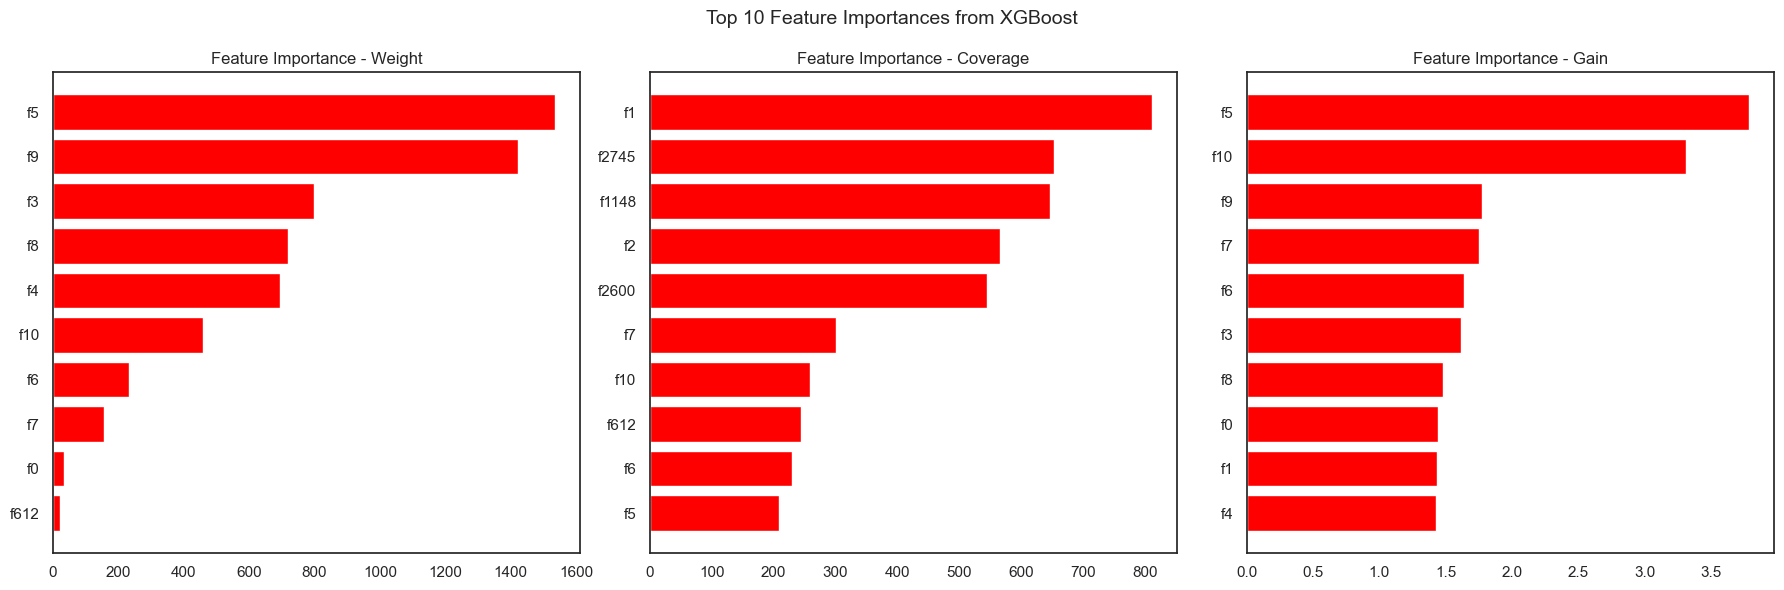

In [99]:
# Vérifier si best_model est bien défini
if 'best_model' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Extraire les features les plus importantes
    importance_types = ['weight', 'cover', 'gain']
    titles = ["Feature Importance - Weight", "Feature Importance - Coverage", "Feature Importance - Gain"]

    for i, imp_type in enumerate(importance_types):
        # Récupérer les importances sous forme de DataFrame
        importance = best_model.get_booster().get_score(importance_type=imp_type)
        importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
        
        # Trier par importance et garder le top 10
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

        # Tracer le graphique
        axes[i].barh(importance_df['Feature'], importance_df['Importance'], color='red')
        axes[i].invert_yaxis()  # Inverser pour que la feature la plus importante soit en haut
        axes[i].set_title(titles[i])

    plt.suptitle("Top 10 Feature Importances from XGBoost", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Erreur : best_model n'est pas défini. Vérifiez que GridSearchCV a bien été exécuté.")

In [117]:
X.columns

Index(['cat_response', 'positive_emojis', 'negative_emojis',
       'num_special_characters', 'num_uppercase_characters',
       'total_characters', 'nombre_point_exclam', 'nombre_point_intero',
       'diff_experience_review', 'diff_review_response', 'commentaire_clean',
       'sentiment_commentaire', 'commentaire_clean_pos_tag'],
      dtype='object')

In [118]:
import shap

In [121]:
# Assurez-vous que X_test a les mêmes colonnes que X
print(X_test.columns)  # Vérifie les colonnes de X_test
print(X.columns)         # Vérifie les colonnes de X

Index(['cat_response', 'positive_emojis', 'negative_emojis',
       'num_special_characters', 'num_uppercase_characters',
       'total_characters', 'nombre_point_exclam', 'nombre_point_intero',
       'diff_experience_review', 'diff_review_response', 'commentaire_clean',
       'sentiment_commentaire', 'commentaire_clean_pos_tag'],
      dtype='object')
Index(['cat_response', 'positive_emojis', 'negative_emojis',
       'num_special_characters', 'num_uppercase_characters',
       'total_characters', 'nombre_point_exclam', 'nombre_point_intero',
       'diff_experience_review', 'diff_review_response', 'commentaire_clean',
       'sentiment_commentaire', 'commentaire_clean_pos_tag'],
      dtype='object')


In [ ]:
# shap.summary_plot(shap_values, x_test_dt)
# Afficher la densité des valeurs SHAP
shap.summary_plot(shap_values, x_test_dt, plot_type="density")

In [110]:
# 2️⃣ Vérifier la distribution des classes avant rééquilibrage
print("Distribution des classes avant rééquilibrage :", Counter(y_train))

# 3️⃣ Choix de la méthode de rééquilibrage (SMOTE ou Random Oversampling)
use_smote = True  # 🔄 Passe à False pour tester l'oversampling aléatoire

Distribution des classes avant rééquilibrage : Counter({5: 3284, 1: 421, 4: 419, 3: 162, 2: 97})


In [131]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [130]:
if use_smote:
    resampler = SMOTE(sampling_strategy='auto', random_state=42)
    print("⚡️ Utilisation de SMOTE")
else:
    resampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    print("⚡️ Utilisation de Random Oversampling")

# Appliquer la méthode choisie
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_transformed, y_train)

print("Distribution des classes après rééquilibrage :", Counter(y_train_resampled))

⚡️ Utilisation de SMOTE
Distribution des classes après rééquilibrage : Counter({5: 3284, 4: 3284, 2: 3284, 1: 3284, 3: 3284})


In [135]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Réindexer les classes pour qu'elles commencent à 0
label_encoder = LabelEncoder()

# Encoder les classes dans y_train et y_test
y_train_encoded = label_encoder.fit_transform(y_train)  # Appliquer le même encodage sur y_train
y_test_encoded = label_encoder.transform(y_test)  # Appliquer l'encodage à y_test

# S'assurer que les données d'entraînement et de test sont rééquilibrées avec les nouvelles classes
# Appliquer également la transformation à y_train_resampled et y_test_transformed si nécessaire

# Re-entraîner le modèle avec les nouvelles classes encodées
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train_encoded)),  # ✅ Auto-détection du nombre de classes
                          max_depth=5, learning_rate=0.1, n_estimators=200, random_state=42)

xgb_model.fit(X_train_resampled, y_train_encoded)

# Prédictions
predictions = xgb_model.predict(X_test_transformed)

# 6️⃣ Ajustement des prédictions si besoin
predictions = label_encoder.inverse_transform(predictions)

# 7️⃣ Évaluation
accuracy = accuracy_score(y_test_encoded, predictions)
print(f'\n🎯 Précision du modèle après rééquilibrage : {accuracy * 100:.2f}%')

print("\n📌 Classification Report :\n", classification_report(y_test_encoded, predictions))

# 8️⃣ Matrice de confusion avec heatmap
cm_xgb = confusion_matrix(y_test_encoded, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Reds", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion XGBoost")
plt.show()

# 9️⃣ Tracer la distribution après rééquilibrage
plt.figure(figsize=(6, 4))
plt.bar(Counter(y_train_encoded).keys(), Counter(y_train_encoded).values(), color='red')
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des classes après rééquilibrage")
plt.show()


XGBoostError: [19:51:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\data.cc:508: Check failed: this->labels.Size() % this->num_row_ == 0 (4383 vs. 0) : Incorrect size for labels.

In [137]:
print(f"Shape de X_train_resampled: {X_train_resampled.shape}")
print(f"Shape de y_train_resampled: {y_train_resampled.shape}")

Shape de X_train_resampled: (16420, 8209)
Shape de y_train_resampled: (16420,)


In [138]:
print(f"Nombre de colonnes (features) dans X_train_resampled: {X_train_resampled.shape[1]}")


Nombre de colonnes (features) dans X_train_resampled: 8209


In [139]:
from sklearn.decomposition import PCA

# Réduction de la dimensionnalité si nécessaire (par exemple, réduire à 1000 dimensions)
pca = PCA(n_components=1000)
X_train_resampled_reduced = pca.fit_transform(X_train_resampled)

# Vérification de la nouvelle forme
print(f"Forme après PCA : {X_train_resampled_reduced.shape}")

Forme après PCA : (16420, 1000)


In [140]:
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train_resampled)),
                          max_depth=5, learning_rate=0.1, n_estimators=200, random_state=42)

xgb_model.fit(X_train_resampled_reduced, y_train_resampled)


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [1 2 3 4 5]

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Appliquer la sélection de caractéristiques avec l'importance de XGBoost
selector = SelectFromModel(xgb_model, threshold="mean", max_features=1000)
X_train_resampled_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Vérifier la nouvelle forme
print(f"Forme après sélection de caractéristiques : {X_train_resampled_selected.shape}")